# corrGcamp6fOgb1_dev

This notebooks takes in the processed OGB-1 and GCaMP6f data, and correlates gcamp6f cell traces with ogb1 mean cluster traces, using the clusters from Baden2016, in order to assign gcamp6f cells to ogb1 clusters.

# TODO:

- integrate cells_per_clu into ogb1 and gcamp6 data structures

- plot cluster histograms: somaArea, DSI
 - do as separate plot (rather than creating one super fig)



- long-term
 - cluster assignment
  - create weights for each clu depending on MI to best cluster vs MIs to next best n clusters? 

 - integrate analysis into DataJoint
 
- code improvement:
 - plotting: make plot functions, e.g. plot_chirp(dataframe=None, traceType=None, triggers=None, showInfo=True) (or plot_chirp)
 - use common plot params
  - DEFINE: plotPars or p.plot = dict(normed=True, ... )
  - PLOT: plt.hist(x, **plotPars)

# Qs:



## Q Archive
- Why so many neg correlations? 
 - bec OFF-cells vs ON-cells

- code improvement?
 - check typical workflow
 - check useful commands
 - function storage in same or other jnb, or outside
 

# Setup

In [1]:
## Library/module setup

# System libs
import os # directory lib
import sys

# Data libs
import h5py # HDF5 lib
import numpy as np # linear alg lib
import pandas as pd # pandas data structures lib
import scipy
import scipy.io as sio
from scipy import stats

# Plotting libs
import matplotlib.pyplot as plt # plotting lib
import seaborn as sns # nice plotting lib
from pylab import rcParams


import warnings
import matplotlib.gridspec as gridspec
from __future__ import print_function

# Misc libs
# for integration of plots into jupyter nb
%matplotlib inline

# Custom libs/mods
sys.path.append('../utils/') # Import path to utility function: norm.py, interp.py
sys.path.append('../ext/') # Import path to external code
import postProc as pop # Import PostProcessing module (functions: normalization, interpolation, QI etc.)

In [2]:
# Reload module
import importlib
importlib.reload(pop)

<module 'postProc' from '../utils/postProc.py'>

In [2]:
# Avoid large figure issues
plt.close()
import gc
gc.collect()

0

In [4]:
# ybauer/gcamp6-ogb1/code/ext/cMaps/cMap_igor.mat

In [122]:
### Parameter setup
p = {}
p.update({
        # I/O parameters        
        'loadDir': '../../data/2P/proc/', # set load root directory        
        'saveDir': '../../data/2P/proc/', # save directory                
#         'loadDir': '/Volumes/busse_lab/users/yannik/data/2P/', # load directory
#         'saveDir': '/Volumes/busse_lab/users/yannik/data/2P/', # save directory
        'fidGcamp6': 'gcamp6Data_gcamp6fKern_7.8Hz.h5', # _gcamp6fKern_40Hz, _foopsi_7.8Hz
        'fidGcamp6Save': 'g6_assigned.mat',        
        'fidOgb1Group': 'BadenEtAl_RGCs_2016_ogb1_group_ogb1Kern_7.8Hz.mat',
        'fidOgb1Clu': 'BadenEtAl_RGCs_2016_ogb1_clu_ogb1Kern_7.8Hz.mat', # _ogb1Kern_40Hz, _foopsi_7.8Hz
#         'cmapDir': '../ext/cMaps/', # Colour map from Baden2016 
#         'cmapFid': 'cMap_igor.mat',
        
        # Set stimuli of interest & var names for dataframe accordingly
        'stim': ["chirp", "bar"], # stimulus        
        
        # Choose if analysing groups or clusters
        'groupVClu': 'Clu', # OPTIONS: 'Group', 'Clu'
        
        # Selection criterion pars
        'corrMethod': 'pearson', # OPTIONS: 'pearson', 'spearman'
        'doNormRho': False, # Normalize correlation values (to avoid stimulus-specific rho-distribution influence)
        'miMethod': 'naive', # OPTIONS: 'naive', 'timeWeighted', 'bar50'
        'miCrit': 0, # MI-percentile criterion; set miCrit = 0 for all cells
        'cluMethod': 'naive', # OPTIONS: 'naive', 'somaDS'
        'largeSomaLim': 136, # Baden2016 (area > 136 mum^2)
        })

# Plot % Print parameters
np.set_printoptions(precision=3, suppress=True) # Mainly for plot legend to avoid overly long entries
rcParams['svg.fonttype'] = 'none' # Important for rendering text as text in .svg savefig (otherwise path)
rcParams['pdf.fonttype'] = 42 # Important for rendering text as text in .pdf savefig (otherwise path)

# Figure parameters
plt.style.use('ggplot')
sns.set_style("white") # Remove background grid (sets for all plots?)
# Standard color map (reverse) (check alternative setup methods later)
sns.set_palette('Blues_r')
# rcParams['lines.linewidth'] = 1

In [4]:
# foo =  sio.loadmat(p['cmapDir']+p['cmapFid'])
# foo['cMap_igor']

In [5]:
rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.mencoder_args': [],
          'animation.mencoder_path': 'mencoder',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
         

In [6]:
p

{'cluMethod': 'naive',
 'corrMethod': 'pearson',
 'doNormRho': False,
 'fidGcamp6': 'gcamp6Data_gcamp6fKern_7.8Hz.h5',
 'fidGcamp6Save': 'g6_assigned.mat',
 'fidOgb1Clu': 'BadenEtAl_RGCs_2016_ogb1_clu_ogb1Kern_7.8Hz.mat',
 'fidOgb1Group': 'BadenEtAl_RGCs_2016_ogb1_group_ogb1Kern_7.8Hz.mat',
 'groupVClu': 'Clu',
 'largeSomaLim': 136,
 'loadDir': '../../data/2P/proc/',
 'miCrit': 0,
 'miMethod': 'naive',
 'saveDir': '../../data/2P/proc/',
 'stim': ['chirp', 'bar']}

# Load ogb1 and gcamp6 data

## Load ogb1

In [7]:
# Load ogb1-group or cluster data (.mat file)
# ogb1: dictionary
if p['groupVClu'] == 'Group':
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Group'])
    p.update({'nOgb1Groups': 32})    
elif p['groupVClu'] == 'Clu':
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Clu'])
    p.update({'nOgb1Groups': 49})    

In [8]:
# Inspect vars
if p['groupVClu'] == 'Group':
    viewData = sio.whosmat(p['loadDir']+p['fidOgb1Group'])
elif p['groupVClu'] == 'Clu':
    viewData = sio.whosmat(p['loadDir']+p['fidOgb1Clu'])    
viewData

[('chirpMean', (249, 49), 'double'),
 ('barDeconvMean', (32, 49), 'double'),
 ('barMeanDeconv', (32, 49), 'double'),
 ('barTime', (1, 32), 'double'),
 ('somaSizeIdx', (49, 1), 'int64'),
 ('barN', (1, 49), 'int64'),
 ('chirpDeconvSd', (249, 49), 'double'),
 ('barMed', (32, 49), 'double'),
 ('barDeconvSd', (32, 49), 'double'),
 ('dsIdx', (49, 1), 'int64'),
 ('chirpMeanDeconv', (249, 49), 'double'),
 ('chirpN', (1, 49), 'int64'),
 ('chirpDeconvMean', (249, 49), 'double'),
 ('chirpTime', (1, 249), 'double'),
 ('barSd', (32, 49), 'double'),
 ('chirpMed', (249, 49), 'double'),
 ('barMean', (32, 49), 'double'),
 ('chirpSd', (249, 49), 'double')]

In [9]:
## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) and get duration for each stimulus
# (.mat files seem to require storage as 2D)
for iStim in p['stim']:
    ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
    ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0] # Get stim duration
    print(ogb1[iStim+'Dur'])
    
## Add trigger times - extract flexibly later
ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
ogb1['barTrigTime'] = [1, 2]    

31.8204915663
4.0


## Load gcamp6 cell data

In [10]:
gcamp6 = pd.read_hdf(p['loadDir']+p['fidGcamp6'], 'data')

In [11]:
print('nCells: %i' %len(gcamp6))
# gcamp6

nCells: 251


# Sort gcamp6 traces by QI

In [12]:
# Insert qi-sorted cell idx as new column of df for each stimulus
# Note: pandas saves row idx w argsort, so to reverse order, we need to do it on an array and reinsert it as series

for iStim in p['stim']:
    gcamp6[iStim+'QiSortIdx'] = pd.Series(np.array(gcamp6[iStim+'Qi']).argsort(axis=0)[::-1]) # [::-1] = descndg order

## Plot gcamp6 cells with high/low QI, both Chirp and Bar stimulus

In [13]:
if False:
    ### Plot gcamp6 cell responses sorted by high/low QI, both to Chirp and Bar stimulus

    # Parameters
    sortCrit = 'chirpQiSortIdx' # Set sort criterion. OPTIONS: chirpQiSortIdx', 'barQiSortIdx'
    # sortOrder = # Ascending or descending
    traceType = 'Med' # Plot mean or median; OPTIONS: 'Mean', 'Med', 'DeconvMean'
    nCells = 5 # Define n cells to plot

    # Figure pre-setup
    rcParams['figure.figsize'] = 12, (nCells)*2 # workaround to adjust fig size
    gs = gridspec.GridSpec(nCells, 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
    sns.set_style("white") # Remove background grid

    # Plot gcamp6 traces of nCells
    for i in range(nCells):

        ## Left: chirp response
        plt.subplot(gs[i, 0])
        stim = p['stim'][0]

        # Avg
        sns.tsplot(gcamp6[stim+traceType][gcamp6[sortCrit][i]].T, time=ogb1[stim+'Time'])#, label='gcamp6-mean')

        # Error area
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceType == 'Mean') | (traceType == 'Med'):
            sdTrace = 'Sd'
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            sdTrace = 'DeconvSd'
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceType][gcamp6[sortCrit][i]] + gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                         gcamp6[stim+traceType][gcamp6[sortCrit][i]] - gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                         alpha=0.15,
    #                      edgecolor='k',
    #                      facecolor='k',
    #                      label='gcamp6-sd',
                        )
        # Add trigger lines
        for j in ogb1[stim+'TrigTime']:
            plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)

        plt.title("cell: {0}, date: {1}, field: {2}, roi: {3}".format(
                gcamp6.index.get_loc(gcamp6[sortCrit][i]),
                gcamp6['date'][gcamp6[sortCrit][i]],
                gcamp6['field'][gcamp6[sortCrit][i]],
                gcamp6['roi'][gcamp6[sortCrit][i]])+
                  "\n$QI_{chirp}$: " + "{0}".format(
                np.round(gcamp6['chirpQi'][gcamp6[sortCrit][i]], 3)),
                loc='left', fontsize=12)
    #     plt.legend()

        ###########################################################################

        ## Right: bar response
        plt.subplot(gs[i, 1])
        stim = p['stim'][1]

        # Avg
        sns.tsplot(gcamp6[stim+traceType][gcamp6[sortCrit][i]].T, time=ogb1[stim+'Time'])#, label='gcamp6-mean')

        # Error area
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceType == 'Mean') | (traceType == 'Med'):
            sdTrace = 'Sd'
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            sdTrace = 'DeconvSd'
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceType][gcamp6[sortCrit][i]] + gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                         gcamp6[stim+traceType][gcamp6[sortCrit][i]] - gcamp6[stim+sdTrace][gcamp6[sortCrit][i]],
                         alpha=0.15,
    #                      edgecolor='k',
    #                      facecolor='k',
    #                      label='gcamp6-sd',
                        )
        # Add trigger lines
        for j in ogb1[stim+'TrigTime']:
            plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)

        plt.title("$QI_{bar}$: " + "{0}".format(np.round(gcamp6['barQi'][gcamp6[sortCrit][i]], 3)), loc='left', fontsize=12)

    # Figure post-setup
    # sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
    sns.plt.gca().set(
        xlabel = 'Time (s)', # info: comments can be put in line here
        ylabel = 'Fluorescence (s.d.)',
        ) # axis labels
    sns.despine(top = True, right = True) # Remove unwanted axis borders
    plt.tight_layout()

# Correlate GCamp6 and OGB-1 data for each stimulus

- Note that stats.spearmanr outputs a correlation matrix of all x-vars and y-vars.
 - This results in matrix [nCell+nClu, nCell+nClu] ≈ [487, 487] (i.e. also cell-cell and clu-clu corrs).
 - For now, we will only look at the cell-clu corrs part of the matrix, i.e. the last [nCell x nClu] entries.
- To get the corrs on a pandas df, we transform the gcamp6 means into a 2D-array, like ogb1ChirpMean

## Spearman rank correlation

In [14]:
if p['corrMethod'] == 'spearman':
    # Parameters
    traceTypeG6 = 'DeconvMean'
    traceTypeO1 = 'DeconvMean'

    # Find cell-group correlations for each stimulus
    for iStim in p['stim']:
        # Get correlation matrix
        rho, pVal = stats.spearmanr(np.array(gcamp6[iStim+traceTypeG6].values.tolist()).T, ogb1[iStim+traceTypeO1], axis=0)

        # Reduce rho matrix to cell-clu correlations (i.e. no cell-cell or clu-clu correlations)
        nCells = gcamp6.shape[0]
        nClus = ogb1[iStim+traceType].shape[1]
        rho = rho[0:nCells, -nClus:]
        pVal = pVal[0:nCells, -nClus:]

        # Insert corrs into df -> for each cell, this will result in a list of corrs, one per cluster
        gcamp6[iStim+'CorrRho'] = pd.Series(list(rho))
        gcamp6[iStim+'CorrPVal'] = pd.Series(list(pVal))


## Pearson product-moment correlation coefficient

In [15]:
if p['corrMethod'] == 'pearson':
    # Parameters
    traceTypeG6 = 'DeconvMean'
    traceTypeO1 = 'DeconvMean'

    # Find cell-group correlations for each stimulus
    for iStim in p['stim']:
        # Get correlation matrix
        rho = pop.pearsonr2D(np.array(gcamp6[iStim+traceTypeG6].values.tolist()), ogb1[iStim+traceTypeO1].T)

        # Normalize (range-norm) rho (to avoid stimulus-specific rho-distribution influence))
    #     rho = rho - np.min(rho) / np.max(rho) - np.min(rho)

        # Insert corrs into df -> for each cell, this will result in a list of corrs, one per cluster/group
        gcamp6[iStim+'CorrRho'] = pd.Series(list(rho))

## Normalize correlations
- bar-correlations are higher than chirp-corrs > bar-corrs might overly influence MI >< normalization could avoid stimulus-specific rho-distribution influence) this

In [16]:
if p['doNormRho']:
    for iStim in p['stim']:
        # Get corrs from df
        rho = np.array(gcamp6[iStim+'CorrRho'].values.tolist())
        
        # Range-normalize rho
        rho = rho - np.min(rho)
        rho =  rho / np.max(rho)
        
        # Re-insert into df
        gcamp6[iStim+'CorrRho'] = pd.Series(list(rho))

## Sort cells and/or groups according to correlation

In [17]:
# Sort cells/groups by correlation for each stimulus
for iStim in p['stim']:
    # Sort groups for each cell: for each gcamp6 cell, sort ogb1 groups according to their stimulus response corr
    groupSortIdx = np.array(gcamp6[iStim+'CorrRho'].values.tolist()).argsort(axis=1)[:,::-1]

    # Insert groupSortIdx into gcamp6 df -> for each cell, this is a list of groups indices sorted by corr
    gcamp6[iStim+'CorrSortIdx'] = pd.Series(list(groupSortIdx))
    
    # Sort cells: For each ogb1 group, sort gcamp6 cells according to their stimulus response correlation
    cellSortIdx = np.array(gcamp6[iStim+'CorrRho'].values.tolist()).argsort(axis=0)[::-1]

    # Insert cellSortIdx into ogb1 dict -> for each ogb1-group, this is a list of cell indices sorted by corr
    ogb1[iStim+'CorrSortIdx'] = cellSortIdx

print(cellSortIdx.shape)    
print(groupSortIdx.shape)

(251, 49)
(251, 49)


## Plot distribution of correlations - max correlation value for each cell

In [18]:
## Get max corrs
for iStim in p['stim']:
    a = np.array(gcamp6[iStim+'CorrRho'].values.tolist())
    b = np.array(gcamp6[iStim+'CorrSortIdx'].values.tolist())[:, 0]
    gcamp6[iStim+'MaxCorrs'] = a[np.arange(a.shape[0]), b] 
    # NOTE: np.arange() creates array > instead of c = a[:, b] forces to step row by row, not apply b to all rows of a

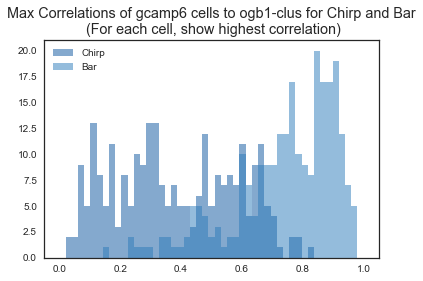

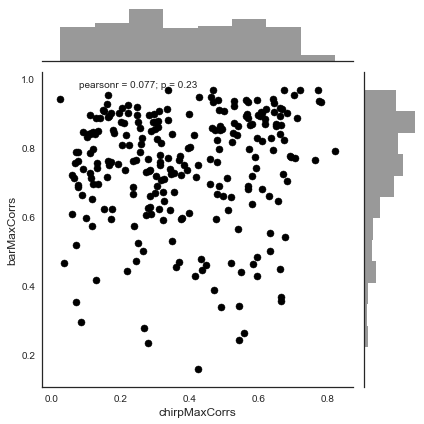

In [19]:
## Plot
# Fig pars
rcParams['figure.figsize'] = [6.0, 4.0]
sns.set_style("white") # Remove background grid

# Plot histogram
bins = np.linspace(0, 1, 50)
plt.hist(gcamp6['chirpMaxCorrs'], bins, alpha=0.5, label='Chirp')
# plt.hold(True)
plt.hist(gcamp6['barMaxCorrs'], bins, alpha=0.5, label='Bar')
plt.title('Max Correlations of gcamp6 cells to ogb1-clus for Chirp and Bar' +
          '\n (For each cell, show highest correlation)')
plt.legend()
plt.show()

# Print median correlation

# Plot scatter hist
# Note: jointplot is fig-lvl > hard to put into gridspec, needs to be positioned after plotting - check later
sns.jointplot(x=gcamp6['chirpMaxCorrs'], y=gcamp6['barMaxCorrs'], color='k')
plt.show()

## Plot gcamp6 cells and their ogb1 groups sorted by stimulus-response correlation

In [20]:
# # Parameters
# sortCrit = 'chirpRho' # OPTIONS: 'chirpRho', 'barRho'
# cellSelect = [0, 2] #range(nGcamp6Cells) # Define cells to plot. FORMAT: [start, stop]
# n = 1 # Define best n matches to plot
# traceType = 'Mean' # Plot mean or median: 'Mean', 'Med'

# tPts = np.linspace(0, stimDurChirp, gcamp6ChirpMean.shape[0]) # Timepoints x-axis

# # Figure pre-setup
# rcParams['figure.figsize'] = 12, cellSelect[1]*2 # workaround adjust fig size
# gs = gridspec.GridSpec(cellSelect[-1], 2, width_ratios=[1,1]) # Generate nxn grid for plotting figures

# # Plot traces
# for i in range(cellSelect[0], cellSelect[1]):
#     # Plot gcamp6 cell
#     plt.subplot(gs[i, 0]) # .set_title('title', fontsize=16) # Set figure title
#     sns.tsplot(gcamp6ChirpMean2[:, i], time=tPts, color='k')

#     # Plot n corr clu (reverse best: n-1::-1)
#     plt.plot(tPts, ogb1ChirpMean[:, groupSortIdxChirp[0:n, i]], alpha=0.9)
#     # Add legend info
#     legendInfo = np.empty(shape=[n, 2])
#     legendInfo[:, 0] = groupSortIdxChirp[0:n, i] # ogb1-group ID
#     legendInfo[:, 1] = np.round(gcamp6Ogb1RhoChirp[groupSortIdxChirp[0:n, i], i], 2) # associated rho-value  
# #     legendInfo[:, 2] = gcamp6Ogb1PValChirp[groupSortIdxChirp[0:n, i], i] # associated p-value    
#     plt.legend(legendInfo, # show rho-values in legend
#                bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='OGB1-group; GCamp6-OGB1-rho')
#     # Add title
#     plt.title("date: {0}, field: {1}, roi: {2}, QI_chirp: {3}".format(
#             gcamp6Meta2.date[i],
#             gcamp6Meta2.field[i],
#             gcamp6Meta2.roi[i],
#             np.round(gcamp6ChirpQi2[i], 3)),
#             loc='left', fontsize=12)    

# # Figure post-setup
# # sns.plt.suptitle('Black: GCamp6 Cells; Blue: Three max. correlating OGB-1 clusters (dark>light)', fontsize=14) # Supertitle
# sns.plt.gca().set(
#     xlabel = 'Time (s)', # info: comments can be put in line here
#     ylabel = 'Fluorescence (s.d.)',
# ) # axis labels
# sns.set_style("white") # Remove background grid (sets for all plots)
# sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.tight_layout()

## Plot ogb1 groups and their gcamp6 cells sorted by stimulus-response correlation

In [21]:
# ### Plot ogb1 clusters and highest correlating gcamp6 cells
# ## Chirp
# # Parameters
# groupSelect = range(nOgb1Groups) # Define groups to plot
# n = 3 # Define best n matches to plot
# tPts = np.linspace(0, stimDurChirp, gcamp6ChirpMean.shape[0]) # Timepoints x-axis

# # Figure pre-setup
# rcParams['figure.figsize'] = 20, groupSelect[-1]*2
# gs = gridspec.GridSpec(groupSelect[-1]+1, 1, width_ratios=[1,1]) # Generate 2x1 grid for plotting figures
# sns.set_palette('Blues_r') # Set color map (reverse) (check alternative setup methods later)

# # Plot traces
# for i in groupSelect:
#     # Plot ogb1 cluster
#     plt.subplot(gs[i, 0]) # .set_title('title', fontsize=16) # Set figure title
#     sns.tsplot(ogb1ChirpMean[:, i], time=tPts, color='k')
# #     plt.plot(tPts, ogb1ChirpMean[:, i], color='k')
#     plt.fill_between(tPts, # Add error area
#                      ogb1ChirpMean[:, i]+ogb1ChirpSd[:, i], ogb1ChirpMean[:, i]-ogb1ChirpSd[:, i],
#                      alpha=0.1, edgecolor='k', facecolor='k')

#     # Plot n corr gcamp6 cells (reverse best: n-1::-1)
#     plt.plot(tPts, gcamp6ChirpMean2[:, cellSortIdxChirp[i, 0:n]], alpha=0.9)

#     # Add legend info
#     legendInfo = np.empty(shape=[n, 2])
#     legendInfo[:, 0] = cellSortIdxChirp[i, 0:n] # gcamp6 cell ID
#     legendInfo[:, 1] = np.round(gcamp6Ogb1RhoChirp[i, [cellSortIdxChirp[i, 0:n]]], 2) # associated rho-value  
#     plt.legend(legendInfo, # show rho-values in legend
#                bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='GCamp6-cell; GCamp6-OGB1-rho')
    
#     # Add title
#     plt.title("RGC group: {0}".format(i+1), loc='left', fontsize=12)      

# # Figure post-setup
# sns.plt.gca().set(
#     xlabel = 'Time (s)', # info: comments can be put in line here
#     ylabel = 'Fluorescence (s.d.)',
# ) # axis labels
# sns.set_style("white") # Remove background grid (sets for all plots)
# sns.despine(top = True, right = True) # Remove unwanted axis borders    
# plt.tight_layout()
# # sns.plt.suptitle('Top to Bottom: 32 OGB-1 RGC groups; Blue: Three max. correlating GCamp6 cells (dark>light)', fontsize=14)


# Get total cell match index (MI)
- **goal**: combine QIs and stimulus-correlations into one total match index  
  
  
- **formula**: $MI = \frac{Qi_{chirp}}{Qi_{chirp} + Qi_{bar}} * \rho_{chirp} + \frac{Qi_{bar}}{Qi_{chirp} + Qi_{bar}} * \rho_{bar}$  
  
  
     - QiChirp & QiBar: [nGcamp6Cell, 1] dimensional row vectors
     - gcamp6Ogb1RhoChirp & gcamp6Ogb1RhoBar: [nOgb1Groups, nGcamp6Cell] matrices

- **result**: MiTotal: [nOgb1Groups, nGcamp6Cell] matrix, indicating RGC cluster proximity weighted by stimulus-relative GCamp6 quality

In [22]:
if p['miMethod'] == 'naive':
    ## Naive MI
    # Calculate match index (MI)
    chirpQiWeight = gcamp6['chirpQi'] / (gcamp6['chirpQi'] + gcamp6['barQi'])
    barQiWeight = gcamp6['barQi'] / (gcamp6['barQi'] + gcamp6['chirpQi'])
    mi = gcamp6['chirpCorrRho'] * chirpQiWeight + gcamp6['barCorrRho'] * barQiWeight

    # Insert MI into df
    gcamp6['mi'] = mi

In [23]:
if p['miMethod'] == 'timeWeighted':
    ## MI weighted by stim length
    # Calculate match index (MI) - with stimDuration weight
    chirpQiWeight = gcamp6['chirpQi'] / (gcamp6['chirpQi'] + gcamp6['barQi'])
    barQiWeight = gcamp6['barQi'] / (gcamp6['barQi'] + gcamp6['chirpQi'])
    
#     chirpNTrials, barNTrials = 5, 24
    chirpDurWeight = ogb1['chirpDur']*chirpNTrials / (ogb1['chirpDur'] + ogb1['barDur']) #*chirpNTrials)
    barDurWeight = ogb1['barDur']*barNTrials / (ogb1['chirpDur'] + ogb1['barDur']) #*barNTrials)

    mi = gcamp6['chirpCorrRho'] * chirpQiWeight * chirpDurWeight + gcamp6['barCorrRho'] * barQiWeight * barDurWeight

    # Insert MI into df
    gcamp6['mi'] = mi

In [24]:
if p['miMethod'] == 'bar50':
    ## MI w 50% weight on bar
    # Calculate match index (MI) - half-weight to bar!
    chirpQiWeight = gcamp6['chirpQi'] / (gcamp6['chirpQi'] + gcamp6['barQi'])
    barQiWeight = gcamp6['barQi'] / (gcamp6['barQi'] + gcamp6['chirpQi'])
    mi = gcamp6['chirpCorrRho'] * chirpQiWeight + gcamp6['barCorrRho'] * barQiWeight * 0.5

    # Insert MI into df
    gcamp6['mi'] = mi

In [31]:
mi

0      [0.544409792573, 0.570233410581, 0.57334394738...
1      [-0.0576079147626, -0.0408989654682, -0.111038...
2      [0.768176586964, 0.772951552187, 0.63106760070...
3      [-0.488613757645, -0.509158046369, -0.31544263...
4      [-0.322148719009, -0.247481528969, -0.30262894...
5      [-0.359794660738, -0.29685336117, -0.322163240...
6      [0.0382142854791, 0.0772047368086, -0.01527405...
7      [0.714811570732, 0.630996997443, 0.50517034998...
8      [0.688975066316, 0.688006149719, 0.47510700136...
9      [-0.461606843382, -0.44303191664, -0.283713592...
10     [-0.156662727108, -0.113724723336, 0.030645049...
11     [-0.101603134745, -0.09669302041, -0.184976107...
12     [-0.0995362313493, -0.118057217659, -0.2057878...
13     [0.360026348971, 0.288314590032, 0.16845088057...
14     [-0.0843999405205, -0.00870796794642, 0.154753...
15     [0.00356605086213, -0.0327806242926, -0.161418...
16     [0.0905074761645, 0.00197109824614, -0.1049021...
17     [0.684788829366, 0.63034

In [33]:
gcamp6

chirpDeconvMean  \
0    [0.182614715746, 0.116743502721, 0.28316401370...   
1    [0.395936570383, 0.484333335227, 0.36619875319...   
2    [0.122236683075, 0.0945549007402, 0.0808013954...   
3    [0.242954470837, 0.267869409971, 0.26737713004...   
4    [0.511943758297, 0.30111678947, 0.421022640162...   
5    [0.258968237474, 0.425280264583, 0.53395035742...   
6    [0.482204098785, 0.271245156505, 0.19992987893...   
7    [0.204827628607, 0.156957303199, 0.13145778277...   
8    [0.0264585650152, 0.0444766040235, 0.047681095...   
9    [0.518635594573, 0.77324662078, 0.67306394422,...   
10   [0.476311412429, 0.379902267673, 0.20797274526...   
11   [0.112334015585, 0.0610995123765, 0.0698512958...   
12   [0.0675388719152, 0.106954232399, 0.1648397885...   
13   [0.138675448873, 0.334136515977, 0.66157268375...   
14   [0.479017543581, 0.581766183574, 0.81189229139...   
15   [0.230876336661, 8.881784197e-17, 0.7332927576...   
16   [0.379786581086, 0.057827200779, 0.40393859335...   
17   [0.995754482232, -3.33066907388e-17, 0.7354486...   
18   [0.295137635016, 0.137021713744, 0.09820394386...   
19   [0.485078048558, 0.0873544504569, 1.0, 0.10790...   
20   [0.625599957309, 0.431025731227, 0.31618333580...   
21   [0.160432608092, 0.140115478527, 0.14373305197...   
22   [0.627485855224, 0.713386505341, 0.42528036266...   
23   [0.291815923641, 0.378866171572, 0.27591217593...   
24   [0.131292247051, 0.0897036418593, 0.1031522998...   
25   [0.40856691752, 0.401042501013, 0.327410220107...   
26   [0.157768540488, 0.0987883480069, 0.1047839973...   
27   [0.826623461434, 0.310712260874, 0.59577441614...   
28   [0.316758188588, 0.218471961611, 0.39413510846...   
29   [0.267875280504, 0.348120892977, 0.20405828988...   
..                                                 ...   
221  [0.413898370938, 0.472238896215, 0.45218137184...   
222  [0.533269960756, 0.24817513364, 0.699632612761...   
223  [0.535914171537, 0.889259744226, 0.66110327558...   
224  [0.875076353714, 0.471535988591, 0.59433832384...   
225  [0.61415149031, 0.464008870106, 0.509597503789...   
226  [0.525457278702, 0.648029055111, 0.70608018593...   
227  [0.604190394969, 0.495523311735, 0.60215182042...   
228  [0.543153153357, 0.488963142506, 0.43260194374...   
229  [0.25154457811, 0.294155644664, 0.339263029049...   
230  [0.356797860056, 0.52959163713, 0.662234786604...   
231  [0.271183534882, 0.00571818805825, 0.273052045...   
232  [0.628863623835, 0.635746365632, 0.76895151925...   
233  [0.785418498685, 0.412470538774, 0.50762864216...   
234  [0.674238674124, 0.607550625717, 0.65840967213...   
235  [0.836192592358, 0.623668923516, 0.55954666280...   
236  [0.638893795464, 0.600632975198, 0.59260007167...   
237  [0.564347165744, 0.471184041516, 0.36104961229...   
238  [0.31301115704, 0.748020046715, 0.811415084395...   
239  [0.643252301844, 0.413570636563, 0.78143541232...   
240  [0.31842018583, 0.203446464212, 0.341119382063...   
241  [0.14497466784, 0.124413399635, 0.091588827392...   
242  [0.392856634297, 0.816705563684, 0.79580978516...   
243  [0.886586796339, 0.911085412086, 0.73402078615...   
244  [0.369737769621, 0.475926168261, 0.23624882759...   
245  [0.341970208018, 0.208170288645, 0.19451422829...   
246  [0.664345950691, 0.713444974339, 0.69803960202...   
247  [0.372077052125, 0.702080611856, 0.38508940934...   
248  [0.43753661644, 0.412881988418, 0.451402117813...   
249  [0.646667294213, 0.610024187453, 0.58558157434...   
250  [0.514334260948, 0.512543766099, 0.63666889640...   

                                         chirpDeconvSd  \
0    [0.302011176476, 0.186499065661, 0.51234073060...   
1    [0.461526717202, 0.392324339998, 0.24295881311...   
2    [0.0608752624143, 0.0557781937903, 0.037605802...   
3    [0.379771023111, 0.268041602557, 0.42118392915...   
4    [0.330802736146, 0.153093080913, 0.19764728626...   
5    [0.11228626748, 0.174952735199, 0.065913269704...   
6    [0.459508836107, 0.074239820307

## Sort cells to groups & groups to cells by MI
- for each cell, sort groups by MI to find best match, and for each group, find best matching cell

In [130]:
miSortIdxGroup.size

12299

In [26]:
# Sort groups for each cell: for each gcamp6 cell, sort ogb1 groups by MI
miSortIdxGroup = np.array(gcamp6['mi'].values.tolist()).argsort(axis=1)[:,::-1]

# Insert miSortIdx into df
gcamp6['miSortIdx'+p['groupVClu']] = pd.Series(list(miSortIdxGroup))

# Sort cells: For each ogb1 group, sort gcamp6 cells by MI
miSortIdxCell = np.array(gcamp6['mi'].values.tolist()).argsort(axis=0)[::-1]
    
# Insert miSortIdx into ogb1 dict -> for each ogb1-group, this is a list of cell indices sorted by MI
ogb1['miSortIdxCell'] = miSortIdxCell

In [27]:
# Get max mi for each cell
maxMi = np.array(gcamp6['mi'].values.tolist())\
    [np.arange(len(gcamp6)), np.array(gcamp6['miSortIdx'+p['groupVClu']].values.tolist())[:, 0]] 

# Insert maxMi into df
gcamp6['maxMi'] = pd.Series(maxMi)

NOTE: 
- the maxMi is also faster and easier method of extracting highest MI cells instead of the convoluted version above
- it also is more robust against cell exclusions

## Plot distribution of max MI-values per cell [nCell]

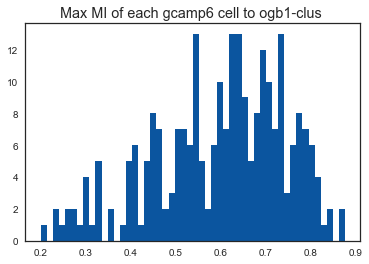

Median maxMI over all cells: 0.624460913216


In [28]:
# Plot
rcParams['figure.figsize'] = [6.0, 4.0]

plt.hist(maxMi, bins=50)
plt.title('Max MI of each gcamp6 cell to ogb1-clus ')
plt.show()

print('Median maxMI over all cells:', np.median(gcamp6['maxMi']))

## Apply MI-criterion to cells
- apply rho-criteria before?

In [29]:
nCellsOrig = gcamp6.index.size # original pre-criterion number of cells

# Apply percentile criterion to gcamp6 data
gcamp6 = gcamp6[gcamp6.maxMi >= np.percentile(gcamp6.maxMi, p['miCrit'])]

# Print summary
print('MI-criterion: %dth percentile = %.3f -> keeping %d/%d cells -> %d cells thrown out.' %
      (p['miCrit'], np.percentile(maxMi, p['miCrit']), gcamp6.index.size, nCellsOrig, (nCellsOrig - gcamp6.index.size)))

# Reset index to reflect new number of cells
gcamp6 = gcamp6.reset_index(drop=True)

MI-criterion: 0th percentile = 0.200 -> keeping 251/251 cells -> 0 cells thrown out.


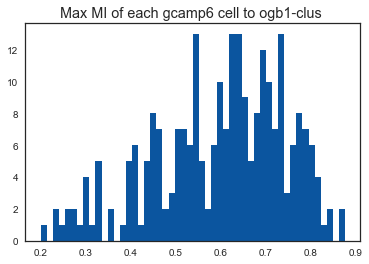

In [30]:
# Plot
rcParams['figure.figsize'] = [6.0, 4.0]

plt.hist(gcamp6.maxMi, bins=50)
plt.title('Max MI of each gcamp6 cell to ogb1-clus ')
plt.show()

## Sort cells by total MI
- just to show 'best' overall cells and their best-matching clusters

In [38]:
# Sort highest total MI values for all cells
MiTotSortIdx = np.array(gcamp6['mi'].values.tolist()).argsort(axis=None)[::-1] # descending order, outputs flattened array

# Unravel x and y (cell and group) coordinates from maxMiIdx
MiTotSortIdxCell, MiTotSortIdxGroup = np.unravel_index(MiTotSortIdx, np.array(gcamp6['mi'].values.tolist()).shape)

In [39]:
# Show max total MI
np.max(np.array(gcamp6['mi'].values.tolist()))

0.87740009144386943

### Sort cells by total MI uniquely
- removing duplicates of cells that have several higher MIs with many clusters than the MI of the next-highest-MI cells

In [40]:
def sortUnique(input):
    """Returns a list of unique values (i.e. removes duplicates) and their indices whilst preserving their original order.
       [uniqueSorted, uniqueSortedIdx] = uniqueSort(input)
       Alternative to explore: OrderedDict.fromkeys(input) <- could not get indices of values!
    """
    uniqueSorted = []
    uniqueSortedIdx = []
    for i, val in enumerate(input):
        if val not in uniqueSorted:
            uniqueSortedIdx.append(i)
            uniqueSorted.append(val)
    return uniqueSorted, uniqueSortedIdx

In [41]:
# Sort cells by total MI uniquely
# (I.e. idx=0 has cell w highest total MI)
MiTotSortIdxCellUni, idx = sortUnique(MiTotSortIdxCell)
MiTotSortIdxGroupUni = MiTotSortIdxGroup[idx]

In [42]:
# Insert total rank index of gcamp6 cells in terms of their MI
# (I.e. cell with idx=0 has highest total MI)
gcamp6['miTotCellSortIdx'] = pd.Series(np.argsort(MiTotSortIdxCellUni))

In [43]:
# check if maxMi gives same result as my convoluted version above- TRUE
print(np.array(np.argsort(gcamp6['maxMi'])[::-1]))
print(np.array(np.argsort(gcamp6['miTotCellSortIdx'])))

[102 182 145 209 186 245 103 142 115 111  24 121 163 178 173 114 169 125
  89  48 219  46  35  52 165  57  12   2 126 175 134  82  42 170  59  11
 152  44  64   3 174 242  96  41  99  27  88 207 148  30 200  92 140 183
 164 157 181  70 156   7 194  66  79  86 101 155   4  87  61 100 185  93
 136 124 188 128   6 240 146   8  17  77 168 167 191  71 179  45 116  29
 234  26 201 127 119  23 109  62 199  65 143 192   0 177  28 227  36 217
 228  97 108 187 162  18  55 218 232 160 176 150 117 210  39 231 193 172
 203 184 208  73 147 216 129  76  49 154 244  40  75 198 233  78 151 220
  51 206 153 158 149  31 107  19 205 241 196 229  90 131 225 110 130  21
 180 235 223 159 211 197  91  68  67 166  34 123 243 213 212  56  63  15
   9 226 171  13  43  58 112 105  81 106  22  80  54 236   5 246  84 249
 190   1  85 120  83  72 239  50  98 202 224 222 133  95  16 161  74 195
  32 113  38 138 139 215 189  69 118 250  14 221  33 214  20  60 137 204
  53 247 104 238 237  47 230 248  94 135 122 144  1

NOTE: is the above nec if we can already argsort by maxMi given for each cell?

### Plot gcamp6 cells (sorted by total MI uniquely) against best-matching ogb1-cluster

#### Re-Sort gcamp6 traces by QI - improve later

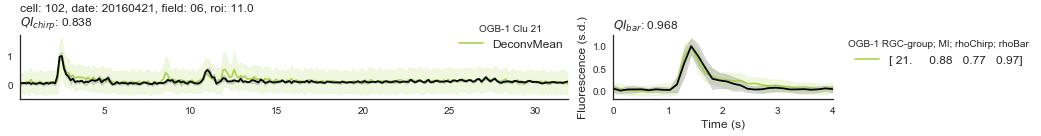

In [44]:
# Parameters
cellSelect = [0, 1] # Define cells to plot [start, stop]
n = 1 # Define best n matches to plot
traceTypeG6 = 'DeconvMean' # Plot mean or median: 'Mean', 'Med'
traceTypeO1 = 'DeconvMean'

# Figure pre-setup
rcParams['figure.figsize'] = 12, (cellSelect[1])*2 # workaround to adjust fig size
gs = gridspec.GridSpec(cellSelect[1], 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
sns.set_style("white") # Remove background grid
# Color map for OGB1-groups/clusters
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.8)[::-1] # Create actual [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.8 # adjust cmap lightness (0.8)

# Plot selected gcamp6 traces and best-matching n ogb1-groups
for i in range(cellSelect[0], cellSelect[1]):    
    
    mi = MiTotSortIdxCellUni[i]
    
    ### Left: chirp response
    plt.subplot(gs[i, 0])
    stim = p['stim'][0]
    ## ogb1
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]],
             color=cmap[gcamp6['miSortIdx'+p['groupVClu']][mi][0:n][0], :],             
             label=traceTypeO1)
    # Error
    # Choose appropriate SD trace for normal vs deconvolved trace
    if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
        sdTrace = 'Sd'
    elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
        sdTrace = 'DeconvSd'
    plt.fill_between(ogb1[stim+'Time'],
                     np.array(ogb1[stim+traceTypeO1][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]] 
                              + ogb1[stim+sdTrace][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]])[:,0],
                     np.array(ogb1[stim+traceTypeO1][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]] 
                            - ogb1[stim+sdTrace][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]])[:,0],
                     edgecolor=cmap[gcamp6['miSortIdx'+p['groupVClu']][mi][0:n][0], :],
                     facecolor=cmap[gcamp6['miSortIdx'+p['groupVClu']][mi][0:n][0], :],
                     alpha=0.15,
                     )    
    # Title
    plt.title("cell: {0}, date: {1}, field: {2}, roi: {3}".format(
            mi,
            gcamp6['date'][mi],
            gcamp6['field'][mi],
            gcamp6['roi'][mi])+
              "\n$QI_{chirp}$: " + "{0}".format(
            np.round(gcamp6['chirpQi'][mi], 3)),
            loc='left', fontsize=12)
    plt.legend(title='OGB-1 '+p['groupVClu']+' '+str(gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T[0]+1),
               loc=1, bbox_to_anchor=(1, 1.25), borderaxespad=0, fontsize=12) # 

    ## gcamp6
    # Average
    sns.tsplot(gcamp6[stim+traceTypeG6][mi], time=ogb1[stim+'Time'], color='k')#, label='gcamp6-mean')
    # Error
    # Choose appropriate SD trace for normal vs deconvolved trace
    if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
        sdTrace = 'Sd'
    elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
        sdTrace = 'DeconvSd'
    plt.fill_between(ogb1[stim+'Time'],
                     gcamp6[stim+traceTypeG6][mi] + gcamp6[stim+sdTrace][mi],
                     gcamp6[stim+traceTypeG6][mi] - gcamp6[stim+sdTrace][mi],
                     edgecolor='k',
                     facecolor='k',
                     alpha=0.15,                     
                    )
    
    ### Right: bar response
    stim = p['stim'][1]
    plt.subplot(gs[i, 1])
    ## ogb1
    # Avg
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]],
            color=cmap[gcamp6['miSortIdx'+p['groupVClu']][mi][0:n][0], :])
    # Error
    # Choose appropriate SD trace for normal vs deconvolved trace
    if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
        sdTrace = 'Sd'
    elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
        sdTrace = 'DeconvSd'
    plt.fill_between(ogb1[stim+'Time'],
                     np.array(ogb1[stim+traceTypeO1][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]] 
                              + ogb1[stim+sdTrace][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]])[:,0],
                     np.array(ogb1[stim+traceTypeO1][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]] 
                            - ogb1[stim+sdTrace][:, gcamp6['miSortIdx'+p['groupVClu']][mi][0:n]])[:,0],
                     edgecolor=cmap[gcamp6['miSortIdx'+p['groupVClu']][mi][0:n][0], :],
                     facecolor=cmap[gcamp6['miSortIdx'+p['groupVClu']][mi][0:n][0], :],
                     alpha=0.15,
                     )  
    # Title
    plt.title("$QI_{bar}$: " + "{0}".format(np.round(gcamp6['barQi'][mi], 3)), loc='left', fontsize=12)

    # Add legend info
    legendInfo = np.empty(shape=[n, 4])
    legendInfo[:, 0] = gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T+1 # ogb1-group ID (+1 bc python-indexing)
    legendInfo[:, 1] = np.round(gcamp6['mi'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2) # associated MI-value
    legendInfo[:, 2] = np.round(gcamp6['chirpCorrRho'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
    legendInfo[:, 3] = np.round(gcamp6['barCorrRho'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
    #     legendInfo[:, 2] = gcamp6Ogb1PValChirp[groupSortIdxChirp[0:n, i], i] # associated p-value    
    legend = plt.legend(legendInfo, # show rho-values in legend
               title='OGB-1 RGC-group; MI; rhoChirp; rhoBar',
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=12) # prop={'size':20}
#     legend.get_title().set_fontsize('12')

    ## gcamp6
    # Average
    sns.tsplot(gcamp6[stim+traceTypeG6][mi], time=ogb1[stim+'Time'], color='k')#, label='gcamp6-mean')
    # Error
    # Choose appropriate SD trace for normal vs deconvolved trace
    if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
        sdTrace = 'Sd'
    elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
        sdTrace = 'DeconvSd'
    plt.fill_between(ogb1[stim+'Time'],
                     gcamp6[stim+traceTypeG6][mi] + gcamp6[stim+sdTrace][mi],
                     gcamp6[stim+traceTypeG6][mi] - gcamp6[stim+sdTrace][mi],
                     edgecolor='k',
                     facecolor='k',
                     alpha=0.15,                     
                    )
    
# Figure post-setup
# sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
sns.plt.gca().set(
    xlabel = 'Time (s)', # info: comments can be put in line here
    ylabel = 'Fluorescence (s.d.)',
    ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders
plt.tight_layout()

# Assign gcamp6 cells to cluster and group

## Naive clustering

In [45]:
if p['cluMethod'] == 'naive':
    # Get best-matching cluster for each cell
    cluIdx = np.array(gcamp6['miSortIdx'+p['groupVClu']].values.tolist())[:, 0]

    # Insert into df
    gcamp6[p['groupVClu'].lower()+'Idx'] = pd.Series(cluIdx)

## Clustering with DS and soma area info

In [46]:
if p['cluMethod'] == 'somaDS':
    ## Get OGB1 DS clusters/groups
    # Note: Var name 'clus' for both clus and groups
    dsClus = np.where(ogb1['dsIdx'] == 1)[0]
    print('ds'+p['groupVClu']+'s:', dsClus)

    ## Get OGB1 large soma clusters
    # Note: Var name 'clus' for both clus and groups
    largeSomaClus = np.where(ogb1['somaSizeIdx'] == 1)[0]
    # Create flexible large soma limit for gcamp6 data: mean + 1 SD
    largeSomaLim = np.mean(gcamp6.somaArea) + np.std(gcamp6.somaArea)
    p.update({'largeSomaLim': largeSomaLim})

    print('largeSoma'+p['groupVClu']+'s:', largeSomaClus)
    print('largeSomaLim:', p['largeSomaLim'])

    ## Cell cluster assignment using DS and soma size info
    # Initialize cell cluster/group index list
    cluIdx = [] # Note: Var name 'clus' for both clus and groups but not in gcamp6 dataframe

    # Loop through all cells
    for i, val in enumerate(gcamp6['miSortIdx'+p['groupVClu']]):
    #     print(val)
        # If the cell is DS (based on DS-p-value <= 0.05) ...
        if gcamp6['dsPVal'][i] <= 0.05:
            # ... reduce array of best-matching clusters to DS-clus
            clus = [x for x in gcamp6['miSortIdx'+p['groupVClu']][i] if x in dsClus]
    #         print('\tDS:', clus)
            # ... also reduce array of best-matching clus to smallSomaClus (according to decision in Baden2016)
            # NOTE: this step is redundant and just to clarify the logic of clu assignment
            # NOTE: intersection of DS and largeSoma is empty in ogb1 by force (but not in gcamp6 for some cells)
            clus = [x for x in clus if x not in largeSomaClus]
    #         print('\t>', clus)

            # Assign as cluIdx the best-matching clu (first entry) 
            cluIdx.append(clus[0])

        # If the cell is non-DS...
        elif gcamp6['dsPVal'][i] > 0.05:
            # ... reduce array of best-matching clusters to non-DS-clus        
            clus = [x for x in gcamp6['miSortIdx'+p['groupVClu']][i] if x not in dsClus]
    #         print('\tnonDS', clus)
            # If the cell exceeds the 'largeSoma threshold'...        
            if gcamp6['somaArea'][i] >= p['largeSomaLim']:
                # ... reduce array of best-matching clus to large-soma-clus
                clus = [x for x in clus if x in largeSomaClus]
    #             print('\tlarge', clus)
            elif gcamp6['somaArea'][i] < p['largeSomaLim']:
                clus = [x for x in clus if x not in largeSomaClus]
    #             print('\tsmall', clus)
            cluIdx.append(clus[0])

    # Insert cluIdx into df
    gcamp6[p['groupVClu'].lower()+'Idx'] = pd.Series(cluIdx, dtype=int)

## Assign gcamp6 cells to groups based on cluster-assignment & give IDs
- follow convention in Baden2016 of summarizing clusters into groups

In [47]:
if p['groupVClu'] == 'Clu':
    ## Define cluster-group mappings - extractable elsewhere?
    clu2grp = np.array([1,2,3,4,4,5,5,5,6,7,8,8,9,10,11,11,12,12,13,14,15,16,17,17,17,18,18,
                19,20,21,22,22,23,24,25,26,27,28,28,29,30,31,31,31,31,31,32,32,32], dtype=int)

    ## Bring indices into Python convention
    clu2grp -= 1 # syntax for array
    # clu2grp = [x - 1 for x in clu2grp] # syntax for list

    ## Convert cluIdx to groupIdx
    c2gIdx = [clu2grp[i] for i in np.array(gcamp6['cluIdx'])]
    # [print(i, '>', clu2grp[i]) for i in np.array(gcamp6['cluIdx'])]

    # Insert groupIdx into gcamp6
    gcamp6['groupIdx'] = c2gIdx
    
# Currently unused
# grp2clu = [[1],[2],[3],[4,5],[6,7,8],[9],[10],[11,12],[13],[14],[15,16],[17,18],[19],[20],[21],[22],[23,24,25],[26,27],
#           [28],[29],[30],[31,32],[33],[34],[35],[36],[37],[38,39],[40],[41],[42,43,44,45,46],[47,48,49]]

# for i,val in enumerate(grp2clu):
#     grp2clu[i] = [x - 1 for x in grp2clu[i]] 

In [48]:
## Assign clu/groupIDs to cells
# Create RGC group IDs
groupIDs = (
    'OFF local, OS',
    'OFF DS',
    'OFF step',
    'OFF slow',
    'OFF alpha sust.',
    '(ON-)OFF "JAM-B" mix',
    'OFF sust.',
    'OFF alpha trans.',
    'OFF "mini" alpha trans.',
    'ON-OFF local-edge "W3"',
    'ON-OFF local',
    'ON-OFF DS 1',
    'ON-OFF DS 2',
    '(ON-)OFF local, OS',
    'ON step',
    'ON DS trans.',
    'ON local trans., OS',
    'ON trans.',
    'ON trans., large',
    'ON high freq.',
    'ON low freq.',
    'ON sust.',
    'ON "mini" alpha',
    'ON alpha',
    'ON DS sust. 1',
    'ON DS sust. 2',
    'ON slow',
    'ON contrast suppr.',
    'ON DS sust. 3',
    'ON local sust., OS',
    'OFF suppr. 1',
    'OFF suppr. 2',    
              )

# Assign groupIDs to cells
if p['groupVClu'] == 'Clu':
    # Convert group labels into clu IDs
    cluIDs = [groupIDs[x] for x in clu2grp]
    # Convert cluIdx to groupID and insert into df
    gcamp6['groupID'] = [cluIDs[i] for i in np.array(gcamp6['cluIdx'])]
    
elif p['groupVClu'] == 'Group':
    # Convert cluIdx to groupID and insert into df
    gcamp6['groupID'] = [groupIDs[i] for i in np.array(gcamp6['groupIdx'])]

## Plot gcamp6 cells (sorted by total MI uniquely) against assigned ogb1-cluster/group

In [49]:
# Avoid large figure issues
plt.close()
import gc
gc.collect()
gc.enable()

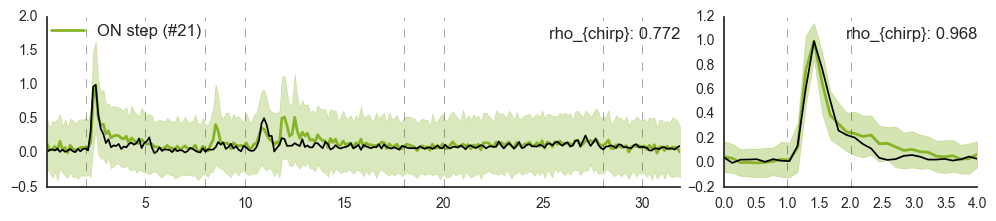

In [44]:
# Plot Parameters
cellSelect = [0, 1] # Define cells to plot [start, stop]
n = 1 # Define best n clu matches to plot
traceTypeG6 = 'DeconvMean' # Plot mean or median: 'Mean', 'Med', 'DeconvMean'
traceTypeO1 = 'DeconvMean' # Plot mean or median: 'Mean', 'Med', 'DeconvMean', 'MeanDeconv'
info = 'mini' # Add info, OPTIONS: 'full', 'mini', ''
ogb1Style = 'errArea' # OGB1 trace plot style; OPTIONS: 'average', errArea', 'auc'
gcamp6Style = 'average' # gcamp6 trace plot style; OPTIONS: 'average', errArea', 'traces'

# Figure pre-setup
rcParams['figure.figsize'] = 12, (cellSelect[1])*2.2 # workaround to adjust fig size
rcParams['lines.linewidth'] = 2
lwG6 = 1.25 # line width gcamp6f
gs = gridspec.GridSpec(cellSelect[1], 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
gs.update(hspace = 0.1, wspace = 0.1)
sns.set_style("white") # Remove background grid

# Color map for OGB1-groups/clusters
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=1)[::-1] # Create actual [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.7 # adjust cmap lightness (0.8)

# Plot selected gcamp6 traces with high MI and assigned ogb1-group/clu
for i in range(cellSelect[0], cellSelect[1]):
    
    # Get cell and its clu (Note: 'clu' may stand for either group or clu depending on p['groupVClu'])
    cell = np.array(np.argsort(gcamp6['maxMi'])[::-1])[i]
    clu = gcamp6[p['groupVClu'].lower()+'Idx'][np.array(np.argsort(gcamp6['maxMi'])[::-1])[i]]
    mi = MiTotSortIdxCellUni[i]
    
    ################################################################
    ### Left: chirp response
    stim = p['stim'][0] # for easier plotting
    plt.subplot(gs[i, 0])
    
    ################################
    ## ogb1
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu], color=cmap[clu], # fine-tuned col
             label="{0} (#{1})".format(gcamp6['groupID'][cell], clu+1))
    # Plot ogb1 error area or fill area under avg curve
    if ogb1Style == 'errArea':
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'        
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceTypeO1][:, clu] + ogb1[stim+sdTrace][:, clu],
                         ogb1[stim+traceTypeO1][:, clu] - ogb1[stim+sdTrace][:, clu],
                         edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.3)
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu],
                        edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.5)
        
    ################################
    ## gcamp6
    # Plot gcamp6 avg, avg+1SD or single traces
    if gcamp6Style == 'average':
        # Average
        sns.tsplot(gcamp6[stim+traceTypeG6][cell], time=ogb1[stim+'Time'], color='k', linewidth=lwG6)#, label='gcamp6-mean')    
    elif gcamp6Style == 'errArea':
        # Average
        sns.tsplot(gcamp6[stim+traceTypeG6][cell], time=ogb1[stim+'Time'], color='k', linewidth=lwG6)#, label='gcamp6-mean')
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'                
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceTypeG6][cell] + gcamp6[stim+sdTrace][cell],
                         gcamp6[stim+traceTypeG6][cell] - gcamp6[stim+sdTrace][cell],
                         edgecolor='k', facecolor='k', alpha=0.15)
    elif gcamp6Style == 'traces':
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sns.tsplot(gcamp6[stim+'Traces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68,
                       color='k', linewidth=lwG6)
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sns.tsplot(gcamp6[stim+'deconvTraces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, 
                       color='k', linewidth=lwG6)
    
    ###########
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)    
    
    if info == 'full':
        # Title
        plt.title("cell: {0}, date: {1}, field: {2}, roi: {3}".format(
                cell,
                gcamp6['date'][cell],
                gcamp6['field'][cell],
                gcamp6['roi'][cell])+
                  "\n$QI_{chirp}: " + "{0}$".format(
                np.round(gcamp6['chirpQi'][cell], 3)),
                position=(0,1), verticalalignment='top', horizontalalignment='left', #loc='left',
                fontsize=12)
        # Legend
        plt.legend(loc=2, bbox_to_anchor=(-0.005, 0.9), borderaxespad=0, fontsize=12)
    elif info == 'mini':
#         plt.title("OGB-1 {0}: {1}".format(p['groupVClu'], clu+1)+
#                 "\n$rho_{chirp}$: " + "{0}".format(np.round(gcamp6[stim+'CorrRho'][cell][clu], 3)),
#                  loc='left', fontsize=12)
        plt.title("\nrho_{chirp}: " + "{0}".format(np.round(gcamp6[stim+'CorrRho'][cell][clu], 3)),
                 fontsize=12, position=(1,1), verticalalignment='top', horizontalalignment='right') #loc='left'        
        plt.legend(loc=2, bbox_to_anchor=(-0.005, 1), borderaxespad=0, fontsize=12)
        
    # Remove axes for all plots except last one
    if (info is not 'full') & (i != cellSelect[1]-1):
        plt.axis('off') # removes only current axis so loop


    #######################################################################################        
    ### Right: bar response
    stim = p['stim'][1]
    plt.subplot(gs[i, 1])
    ################################
    ## ogb1
    # Avg
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu], color=cmap[clu]) # fine-tuned col
    # Plot ogb1 error area or fill area under avg curve
    if ogb1Style == 'errArea':
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'        
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceTypeO1][:, clu] + ogb1[stim+sdTrace][:, clu],
                         ogb1[stim+traceTypeO1][:, clu] - ogb1[stim+sdTrace][:, clu],
                         edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.35, label='1 SD')
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu],
                        edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.5)
    
    ################################
    ## gcamp6
    # Plot gcamp6 avg+1SD or single traces
    if gcamp6Style == 'average':
        # Average
        sns.tsplot(gcamp6[stim+traceTypeG6][cell], time=ogb1[stim+'Time'], color='k', linewidth=lwG6)#, label='gcamp6-mean')
    elif gcamp6Style == 'errArea':
        # Average
        sns.tsplot(gcamp6[stim+traceTypeG6][cell], time=ogb1[stim+'Time'], color='k', linewidth=lwG6)#, label='gcamp6-mean')
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'                
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceTypeG6][cell] + gcamp6[stim+sdTrace][cell],
                         gcamp6[stim+traceTypeG6][cell] - gcamp6[stim+sdTrace][cell],
                         edgecolor='k', facecolor='k', alpha=0.15)
    elif gcamp6Style == 'traces':    
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sns.tsplot(gcamp6[stim+'Traces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, 
                       color='k', linewidth=lwG6)
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sns.tsplot(gcamp6[stim+'deconvTraces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, 
                       color='k', linewidth=lwG6)

    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)
    
    if info == 'full':
        # Title
        plt.title("QI_{bar}: " + "{0}".format(np.round(gcamp6['barQi'][cell], 3)), 
                  fontsize=12, position=(1,1), verticalalignment='top', horizontalalignment='right') #loc='left'
    elif info == 'mini':
        # Title
        plt.title("\nrho_{chirp}: " + "{0}".format(np.round(gcamp6[stim+'CorrRho'][cell][clu], 3)),
                  fontsize=12, position=(1,1), verticalalignment='top', horizontalalignment='right') #loc='left'

#         # Add legend info
#         legendInfo = np.empty(shape=[n, 4])
#         legendInfo[:, 0] = clu+1 # ogb1-group ID (+1 bc python-indexing)
#         legendInfo[:, 1] = np.round(gcamp6['mi'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2) # associated MI-value
#         legendInfo[:, 2] = np.round(gcamp6['chirpCorrRho'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
#         legendInfo[:, 3] = np.round(gcamp6['barCorrRho'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
#             legendInfo[:, 2] = gcamp6Ogb1PValChirp[groupSortIdxChirp[0:n, i], i] # associated p-value    
#         legend = plt.legend(legendInfo, # show rho-values in legend
#                    title='OGB-1 RGC-group; MI; rhoChirp; rhoBar',
#                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=12) # prop={'size':20}
#         legend.get_title().set_fontsize('12')
    # Remove axes for all plots except last one
    if (info is not 'full') & (i != cellSelect[1]-1):
        plt.axis('off') # removes only current axis so loop
            
# Figure post-setup
# sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
if info == 'full':
    sns.plt.gca().set(
        xlabel = 'Time (s)', # info: comments can be put in line here
        ylabel = 'Fluorescence (s.d.)',
        ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.tight_layout()

# Save figure
# plt.savefig('../../results/figs/cellVcell/30-60_2.svg', dpi=1200)



# Get gcamp6f vs OGB-1 cluster averages

Note: the usual workflow is to (1) correlate gcamp6 cells to average ogb1 **cluster**-traces, (2) assign gcamp6 cells to **clusters**, (3) convert the assignment from **cluster to group**, and (4) plot the average gcamp6 **group** against ogb1 **groups**.

Therefore, in that case we need to reload the ogb1 **group** traces.

In [50]:
# Parameters
p.update({'plotCluVGroup': 'Clu'}) # Set whether to plot groups or clus; OPTIONS: 'Group', 'Clu'

# Load/Re-load ogb1 data if necessary
if (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Group'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Group'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Group'])) # Show loaded data
    p.update({'nOgb1Groups': 32})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
    
elif (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Clu'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Clu'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Clu'])) # Show loaded data
    p.update({'nOgb1Groups': 49})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Group'):
    print('No need to reload')
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Clu'):
    print('Invalid analysis request.')

[('chirpMean', (249, 49), 'double'), ('barDeconvMean', (32, 49), 'double'), ('barMeanDeconv', (32, 49), 'double'), ('barTime', (1, 32), 'double'), ('somaSizeIdx', (49, 1), 'int64'), ('barN', (1, 49), 'int64'), ('chirpDeconvSd', (249, 49), 'double'), ('barMed', (32, 49), 'double'), ('barDeconvSd', (32, 49), 'double'), ('dsIdx', (49, 1), 'int64'), ('chirpMeanDeconv', (249, 49), 'double'), ('chirpN', (1, 49), 'int64'), ('chirpDeconvMean', (249, 49), 'double'), ('chirpTime', (1, 249), 'double'), ('barSd', (32, 49), 'double'), ('chirpMed', (249, 49), 'double'), ('barMean', (32, 49), 'double'), ('chirpSd', (249, 49), 'double')]
31.8204915663
4.0


## Get gcamp6 and ogb1 cluster mean traces
### do later

- use code from plot for mean traces
- choose whether to do clus or groups by referring to above chosen param
- for all stimuli
- do one trace or all trace types?
 - one trace, chosen before (so plot will be forced to use same traces)

- save as pd df or dict: gcamp6fClus
 - chirpSingle, barSingle
  - if df: [nClu rows, singles[time, trial]]
  - if dict: [time, trial, clu]
 - chirpAvg, ...
 - chirpSd, ...
 - n
 - cells_per_cluGcamp6 (added later in analysis)
 
 ...

 - soma Areas? or simpler to just use gcamp6? < for histograms
 - DSI? or simpler to just use gcamp6? < for histograms

In [51]:
# Parameters
cluSelect = [0, 2] #p['nOgb1Groups']] # Select clusters to plot; OPTIONS: all clus: [0, p['nOgb1Groups']]
traceTypeG6 = 'DeconvMean' # Plot mean or median; OPTIONS: 'Mean', 'Median', 'DeconvMean'
traceTypeO1 = 'DeconvMean' # Plot mean or median; OPTIONS: 'Mean', 'Median', 'DeconvMean', 'MeanDeconv'

# Define clu depending on whether to analyze clus or groups
if p['plotCluVGroup'] == 'Clu':
    clu = gcamp6.cluIdx
elif p['plotCluVGroup'] == 'Group':
    clu = gcamp6.groupIdx
    
    
for i in range(cluSelect[0], cluSelect[1]):


SyntaxError: unexpected EOF while parsing (<ipython-input-51-8479600a140a>, line 13)

## Plot gcamp6 cell cluster/group averages against ogb1 cluster/group averages

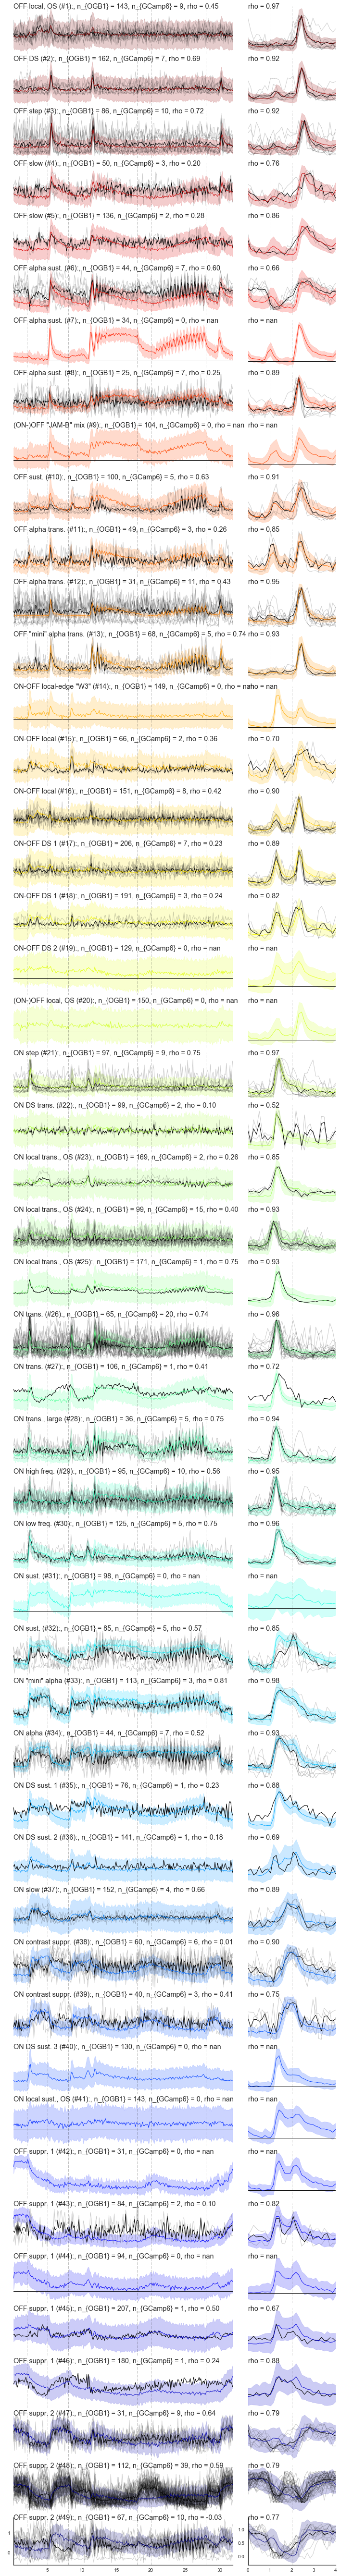

In [53]:
# NOTE: the Latex compiler seems to have issues here, maybe due to large number of figures. 
#  Text is plotted w/o latex for now
# Avoid large figure issues
plt.close()
import gc
gc.collect()

# Parameters
cluSelect = [0, p['nOgb1Groups']] # Select clusters to plot; OPTIONS: all clus: [0, p['nOgb1Groups']]
traceTypeG6 = 'DeconvMean' # Plot mean or median; OPTIONS: 'Mean', 'Median', 'DeconvMean'
traceTypeO1 = 'DeconvMean' # Plot mean or median; OPTIONS: 'Mean', 'Median', 'DeconvMean', 'MeanDeconv'
gcamp6Style = 'single' # Plot gcamp6 single traces or average; OPTIONS: 'single', 'avg'
ogb1Style = 'errArea' # OGB1 trace plot style; OPTIONS: 'errArea', 'auc'
addInfo = False # Add info or make compact plot

# Define clu depending on whether to plot clus or groups
if p['plotCluVGroup'] == 'Clu':
    clu = gcamp6.cluIdx
elif p['plotCluVGroup'] == 'Group':
    clu = gcamp6.groupIdx

# Figure pre-setup
rcParams['figure.figsize'] = 12, p['nOgb1Groups']*2 # workaround to adjust fig size
gs = gridspec.GridSpec(p['nOgb1Groups'], 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
gs.update(hspace = 0.1, wspace = 0.1)
sns.set_style("white") # Remove background grid (sets for all plots?)
rcParams['lines.linewidth'] = 1

# Color map
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.9)[::-1] # 0.8#Create actual [n, 4] array of colors
cmap[:,0:3] = cmap[:,0:3]*1 # adjust cmap lightness

# Initialize clu-clu mean correlation var
chirpR = np.zeros((ogb1[stim+traceTypeO1].shape[1], 2))
barR = np.zeros((ogb1[stim+traceTypeO1].shape[1], 2))

# Go through each cluster/group
for i in range(cluSelect[0], cluSelect[1]):
    #######################################################################################
    ### Left: Chirp
    
    plt.subplot(gs[i, 0])
    stim = p['stim'][0] # for easier plotting
    
    ############################
    ## GCamp6 cluster
    # Get single traces, average & SD
    traceType = traceTypeG6
    single = np.array(gcamp6[stim+traceType][clu == i].values.tolist()).T # Get single traces

    # If cluster is assigned cells, process traces
    if (single.any()):
        # Normalize traces depending on trace type
        if traceType == 'Mean':
            single = pop.normalize(single, mode='meanMax')
        elif traceType == 'Med':
            single = pop.normalize(single, mode='medMax') # Baden2016
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            single = pop.normalize(single, mode='meanR') # range-norm due to non-neg of deconv traces

        avg = np.mean(single, axis=1)
        sd = np.std(single, axis=1)
        n = single.shape[1] # n cells

    # else if cluster empty, assign line at 0
    elif (not single.any()):
        single = np.zeros(len(ogb1[stim+'Time']))
        avg = np.zeros(len(ogb1[stim+'Time']))
        sd = np.zeros(len(ogb1[stim+'Time']))
        n = 0
    
    # Plot single traces or avg
    if gcamp6Style == 'single':
        # Plot single traces
        if (traceType == 'Mean') | (traceType == 'DeconvMean'):
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.mean, err_style='unit_traces', color='k', alpha=1)
        elif traceType == 'Med':
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.median, err_style='unit_traces', color='k', alpha=1)

    elif gcamp6Style == 'avg':
        # Plot average
        sns.tsplot(avg.T, time=ogb1[stim+'Time'], color='k')
        # Plot error

        plt.fill_between(ogb1[stim+'Time'],
                         avg + sd, avg - sd,
                         edgecolor='k',
                         facecolor='k',
                         alpha=0.15,                     
                        )
    
    ###########################    
    ## OGB1 cluster
    traceType = traceTypeO1    
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceType][:, i], color=cmap[i,:], label=traceType)
    # Plot error or area under avg curve
    if ogb1Style == 'errArea':
        
        # Error        
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceType == 'Mean') | (traceType == 'Med'):
            sdTrace = 'Sd'
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            sdTrace = 'DeconvSd'
            
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceType][:, i] + ogb1[stim+sdTrace][:, i],
                         ogb1[stim+traceType][:, i] - ogb1[stim+sdTrace][:, i],
                         edgecolor=cmap[i,:],
                         facecolor=cmap[i,:],
                         alpha=0.2, # Note: alpha specified here ignores alpha in cmap
                         label='1 SD',
                         )
        
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceType][:, i],
                        edgecolor=cmap[i], facecolor=cmap[i], alpha=0.4)
    
    #############################
    
    # Get correlation
    if (single.any()):
        chirpR[i] = scipy.stats.pearsonr(ogb1[stim+traceType][:, i], avg)
    elif (not single.any()):
        chirpR[i] = np.nan
        
    if addInfo:
        # legend
        plt.legend(title='OGB-1 '+p['groupVClu'], loc=1, bbox_to_anchor=(1, 1.25), borderaxespad=0, fontsize=12)    
    
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)    
    
    # Title
    if p['plotCluVGroup'] == 'Clu':
        labels = cluIDs
    elif p['plotCluVGroup'] == 'Group':
        labels = groupIDs
#     plt.title('OGB-1 vs GCamp6 %s %s: #%d \n n_OGB-1 = %d, n_GCamp6 = %d' #$n_{OGB-1} = %d$,
#               %(p['groupVClu'], traceType.lower(), i+1, ogb1[stim+'N'][0,i], n)) #ogb1[stim+'N'][0,i],
#     plt.title('$n_{OGB1} = %d$, $n_{GCamp6} = %d$' % (ogb1[stim+'N'][0,i], n), loc='left')
    # Note: sames as gca().set_title(s, *args, **kwargs)
    plt.title('%s (#%d):, n_{OGB1} = %d, n_{GCamp6} = %d, rho = %.2f' % \
              (labels[i], i+1, ogb1[stim+'N'][0,i], n, chirpR[i,0]), \
              position=(0,1), verticalalignment='top', horizontalalignment='left')#loc='left')
    
    # Remove axes for all plots except last one
    if (not addInfo) & (i != cluSelect[1]-1):
        plt.axis('off') # removes only current axis so loop
    
    #######################################################################################
    ### Right: bar
    plt.subplot(gs[i, 1])
    stim = p['stim'][1] # for easier plotting

    
    ############################
    ## GCamp6 cluster
    # Get single traces, average & SD
    traceType = traceTypeG6
    single = np.array(gcamp6[stim+traceType][clu == i].values.tolist()).T # Get single traces

    # If cluster is assigned cells, process traces
    if (single.any()):
        # Normalize traces depending on trace type
        if traceType == 'Mean':
            single = pop.normalize(single, mode='meanMax')
        elif traceType == 'Med':
            single = pop.normalize(single, mode='medMax') # Baden2016
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            single = pop.normalize(single, mode='meanR') # range-norm due to non-neg of deconv traces

        avg = np.mean(single, axis=1)
        sd = np.std(single, axis=1)
        n = single.shape[1] # n cells
        
    # else if cluster empty, assign line at 0
    elif (not single.any()):
        single = np.zeros(len(ogb1[stim+'Time']))
        avg = np.zeros(len(ogb1[stim+'Time']))
        sd = np.zeros(len(ogb1[stim+'Time']))
        n = 0
    
    # Plot single traces or avg
    if gcamp6Style == 'single':
        # Plot single traces
        if (traceType == 'Mean') | (traceType == 'DeconvMean'):
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.mean, err_style='unit_traces', color='k', alpha=1)
        elif traceType == 'Med':
            sns.tsplot(single.T, time=ogb1[stim+'Time'], estimator=np.median, err_style='unit_traces', color='k', alpha=1)

    elif gcamp6Style == 'avg':
        # Plot average
        sns.tsplot(avg.T, time=ogb1[stim+'Time'], color='k')
        # Plot error
        plt.fill_between(ogb1[stim+'Time'],
                         avg + sd, avg - sd,
                         edgecolor='k',
                         facecolor='k',
                         alpha=0.15,                     
                        )
    
    ############################
    ## OGB1-cluster
    traceType = traceTypeO1    
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceType][:, i],            
             color=cmap[i,:],
             label=traceType)
    # Plot error or area under avg curve
    if ogb1Style == 'errArea':
        
        # Error        
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceType == 'Mean') | (traceType == 'Med'):
            sdTrace = 'Sd'
        elif (traceType == 'DeconvMean') | (traceType == 'MeanDeconv'):
            sdTrace = 'DeconvSd'
            
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceType][:, i] + ogb1[stim+sdTrace][:, i],
                         ogb1[stim+traceType][:, i] - ogb1[stim+sdTrace][:, i],
                         edgecolor=cmap[i,:],
                         facecolor=cmap[i,:],
                         alpha=0.2,
                         label='1 SD',
                         )
        
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceType][:, i],
                        edgecolor=cmap[i], facecolor=cmap[i], alpha=0.4)
    
    ############################
    # Get correlation
    if (single.any()):
        barR[i] = scipy.stats.pearsonr(ogb1[stim+traceType][:, i], avg)
    elif (not single.any()):
        barR[i] = np.nan
        
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)    
    
    # Bar stim title
    plt.title('rho = %.2f' % (barR[i,0]), position=(0,1), \
              verticalalignment='top', horizontalalignment='left')#loc='left'

    # Remove axes for all plots except last one
    if (not addInfo) & (i != cluSelect[1]-1):
        plt.axis('off') # removes only current axis so loop        

# Figure post-setup
# sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
if addInfo:
    sns.plt.gca().set(
        xlabel = 'Time (s)', # info: comments can be put in line here
        ylabel = 'Fluorescence (s.d.)',
        ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.tight_layout()
plt.savefig('../../results/figs/cluVclu/kern_7.8Hz.svg', dpi=1200)

# plt.close()

### Get mean and median correlation between OGB-1 and GCaMP6f clusters
- NOTE: this is just the quick way of teasing the info out of the plot cell above. The plot cell is currently too complex, and instead there will be a separate analysis cell before, from which the plotting cell just gets the data

In [54]:
print('cluster average trace correlations:')
print('mean_chirp:\t', np.nanmean(chirpR[:,0]))
print('median_chirp:\t', np.nanmedian(chirpR[:,0]))

print('mean_bar:\t', np.nanmean(barR[:,0]))
print('median_bar:\t', np.nanmedian(barR[:,0]))

cluster average trace correlations:
mean_chirp:	 0.446368736953
median_chirp:	 0.42768114857
mean_bar:	 0.852333516373
median_bar:	 0.888687922115


## Get gcamp6 and ogb1 cluster correlations / match
 - use MI as simple proxy instead of correlating mean traces

In [55]:
# Define clu depending on whether to plot clus or groups
if p['plotCluVGroup'] == 'Clu':
    clu = gcamp6.cluIdx
elif p['plotCluVGroup'] == 'Group':
    clu = gcamp6.groupIdx
    
meanMi = np.zeros((p['nOgb1Groups'], ), dtype=float) # Initialize
for i in range(p['nOgb1Groups']):
    meanMi[i] = np.mean(gcamp6.maxMi[clu == i])

print('meanMi:', meanMi)

meanMiTot = np.nanmean(meanMi)
print('meanMiTot:', meanMiTot)

meanMi: [ 0.67   0.72   0.644  0.511  0.612  0.513    nan  0.582    nan  0.613
  0.581  0.649  0.763    nan  0.434  0.651  0.639  0.516    nan    nan
  0.671  0.351  0.569  0.592  0.849  0.662  0.611  0.703  0.625  0.778
    nan  0.561  0.807  0.633  0.649  0.562  0.632  0.485  0.446    nan
    nan    nan  0.522    nan  0.598  0.636  0.562  0.502  0.469]
meanMiTot: 0.604488489431


# Get number of cells per cluster/group

Note on alternatives tested:
 - sns.countplot(gcamp6['cluIdx']) # ignores clusters w zero counts
 - gcamp6['cluIdx'].value_counts() # ignores clusters w zero counts

In [56]:
# Set whether to plot groups or clus
p.update({'plotCluVGroup': 'Group'}) # OPTIONS: 'Group', 'Clu'

# Load/Re-load ogb1 data if necessary
if (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Group'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Group'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Group'])) # Show loaded data
    p.update({'nOgb1Groups': 32})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
    
elif (p['groupVClu'] == 'Clu') & (p['plotCluVGroup'] == 'Clu'):
    ## Load stuff
    ogb1 = sio.loadmat(p['loadDir']+p['fidOgb1Clu'])
    print(sio.whosmat(p['loadDir']+p['fidOgb1Clu'])) # Show loaded data
    p.update({'nOgb1Groups': 49})
    
    ## Reshape time vectors from 2D into 1D vector (i.e. from [1, n] to [0, n]) for each stimulus
    # (.mat files seem to require storage as 2D)
    for iStim in p['stim']:
        ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
        ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0]
        print(ogb1[iStim+'Dur'])    
    
    ## Add trigger times - extract flexibly later
    ogb1['chirpTrigTime'] = [2, 5, 8, 10, 18, 20, 28, 30]
    ogb1['barTrigTime'] = [1, 2] 
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Group'):
    print('No need to reload')
elif (p['groupVClu'] == 'Group') & (p['plotCluVGroup'] == 'Clu'):
    print('Invalid analysis request.')

# Reconf color map
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.8)[::-1] # Create actual [n, 4] array of colors
cmap[:,0:3] = cmap[:,0:3]*0.8 # adjust cmap lightness    

[('chirpMean', (249, 32), 'double'), ('barDeconvMean', (32, 32), 'double'), ('barMeanDeconv', (32, 32), 'double'), ('barTime', (1, 32), 'double'), ('somaSizeIdx', (32, 1), 'int64'), ('barN', (1, 32), 'int64'), ('chirpDeconvSd', (249, 32), 'double'), ('barMed', (32, 32), 'double'), ('barDeconvSd', (32, 32), 'double'), ('dsIdx', (32, 1), 'int64'), ('chirpMeanDeconv', (249, 32), 'double'), ('chirpN', (1, 32), 'int64'), ('chirpDeconvMean', (249, 32), 'double'), ('chirpTime', (1, 249), 'double'), ('barSd', (32, 32), 'double'), ('chirpMed', (249, 32), 'double'), ('barMean', (32, 32), 'double'), ('chirpSd', (249, 32), 'double')]
31.8204915663
4.0


In [57]:
## Get Gcamp6 cells per cluster/group

# Define clu depending on whether to plot clus or groups
if p['plotCluVGroup'] == 'Clu':
    clu = gcamp6.cluIdx
elif p['plotCluVGroup'] == 'Group':
    clu = gcamp6.groupIdx

cells_per_clu = np.zeros((p['nOgb1Groups'], ), dtype=int) # Initialize
for i in range(p['nOgb1Groups']):
    cells_per_clu[i] = len(gcamp6[clu == i])
print('cells_per_clu gcamp6:\n', cells_per_clu)
print('nCells gcamp6:', sum(cells_per_clu))

# Get gcamp6f cell percentage per cluster
cells_per_clu_g6_perc = pop.percentage(cells_per_clu, sum(cells_per_clu))
print('Check if percentages add up to 100: %.6f' %sum(cells_per_clu_g6_perc))

# Get nClus with nCells > x
min_cpc = 1
print('Number of clusters with less than %i cell(s): %i' % (min_cpc, np.shape(cells_per_clu[cells_per_clu > min_cpc])[0]))

cells_per_clu gcamp6:
 [ 9  7 10  5 14  0  5 14  5  0 10 10  0  0  9  2 18 21  5 10  5  5  3  7  1
  1  4  9  0  0  4 58]
nCells gcamp6: 251
Check if percentages add up to 100: 100.000000
Number of clusters with less than 1 cell(s): 24


In [58]:
# Get OGB1 cell percentage per cluster
cells_per_clu_o1_perc = pop.percentage(ogb1['chirpN'][0], sum(ogb1['chirpN'][0]))

In [59]:
# Make cells_per_clu into df
cpc = pd.DataFrame({
    'groupIdx': np.arange(p['nOgb1Groups']), 
    'g6_perc':  cells_per_clu_g6_perc,
    'g6_n':     cells_per_clu,
    'o1_perc':  cells_per_clu_o1_perc,
    'o1_n':     ogb1['chirpN'][0],
    'color': pd.Series(list(cmap)),
    })
#     columns = ['g6_perc', 'o1_perc'])

# Bring some data from 'wide' into 'long' format for some plots
cpc2 = pd.melt(cpc, id_vars=['groupIdx', 'color'], value_vars=['g6_perc', 'o1_perc'],
        var_name='dataset', value_name='cpc_perc')

In [61]:
cpc2

groupIdx                                              color  dataset  \
0          0                               [0.4, 0.0, 0.0, 0.8]  g6_perc   
1          1                    [0.514081996435, 0.0, 0.0, 0.8]  g6_perc   
2          2                     [0.62816399287, 0.0, 0.0, 0.8]  g6_perc   
3          3        [0.742245989305, 0.0122004357298, 0.0, 0.8]  g6_perc   
4          4                    [0.8, 0.116775599129, 0.0, 0.8]  g6_perc   
5          5                    [0.8, 0.209731299927, 0.0, 0.8]  g6_perc   
6          6                    [0.8, 0.302687000726, 0.0, 0.8]  g6_perc   
7          7                    [0.8, 0.395642701525, 0.0, 0.8]  g6_perc   
8          8                    [0.8, 0.500217864924, 0.0, 0.8]  g6_perc   
9          9                    [0.8, 0.593173565723, 0.0, 0.8]  g6_perc   
10        10                    [0.8, 0.686129266521, 0.0, 0.8]  g6_perc   
11        11  [0.76660341556, 0.77908496732, 0.0075901328273...  g6_perc   
12        12        [0.675521821632, 0.8, 0.0986717267552, 0.8]  g6_perc   
13        13          [0.594560404807, 0.8, 0.17963314358, 0.8]  g6_perc   
14        14         [0.513598987982, 0.8, 0.260594560405, 0.8]  g6_perc   
15        15          [0.432637571157, 0.8, 0.34155597723, 0.8]  g6_perc   
16        16          [0.34155597723, 0.8, 0.432637571157, 0.8]  g6_perc   
17        17         [0.260594560405, 0.8, 0.513598987982, 0.8]  g6_perc   
18        18          [0.17963314358, 0.8, 0.594560404807, 0.8]  g6_perc   
19        19        [0.0986717267552, 0.8, 0.675521821632, 0.8]  g6_perc   
20        20  [0.00759013282732, 0.729411764706, 0.766603415...  g6_perc   
21        21                    [0.0, 0.629019607843, 0.8, 0.8]  g6_perc   
22        22                     [0.0, 0.52862745098, 0.8, 0.8]  g6_perc   
23        23                    [0.0, 0.428235294118, 0.8, 0.8]  g6_perc   
24        24                    [0.0, 0.315294117647, 0.8, 0.8]  g6_perc   
25        25                    [0.0, 0.214901960784, 0.8, 0.8]  g6_perc   
26        26                    [0.0, 0.114509803922, 0.8, 0.8]  g6_perc   
27        27                   [0.0, 0.0141176470588, 0.8, 0.8]  g6_perc   
28        28                    [0.0, 0.0, 0.742245989305, 0.8]  g6_perc   
29        29                     [0.0, 0.0, 0.62816399287, 0.8]  g6_perc   
..       ...                                                ...      ...   
34         2                     [0.62816399287, 0.0, 0.0, 0.8]  o1_perc   
35         3        [0.742245989305, 0.0122004357298, 0.0, 0.8]  o1_perc   
36         4                    [0.8, 0.116775599129, 0.0, 0.8]  o1_perc   
37         5                    [0.8, 0.209731299927, 0.0, 0.8]  o1_perc   
38         6                    [0.8, 0.302687000726, 0.0, 0.8]  o1_perc   
39         7                    [0.8, 0.395642701525, 0.0, 0.8]  o1_perc   
40         8                    [0.8, 0.500217864924, 0.0, 0.8]  o1_perc   
41         9                    [0.8, 0.593173565723, 0.0, 0.8]  o1_perc   
42        10                    [0.8, 0.686129266521, 0.0, 0.8]  o1_perc   
43        11  [0.76660341556, 0.77908496732, 0.0075901328273...  o1_perc   
44        12        [0.675521821632, 0.8, 0.0986717267552, 0.8]  o1_perc   
45        13          [0.594560404807, 0.8, 0.17963314358, 0.8]  o1_perc   
46        14         [0.513598987982, 0.8, 0.260594560405, 0.8]  o1_perc   
47        15          [0.432637571157, 0.8, 0.34155597723, 0.8]  o1_perc   
48        16          [0.34155597723, 0.8, 0.432637571157, 0.8]  o1_perc   
49        17         [0.260594560405, 0.8, 0.513598987982, 0.8]  o1_perc   
50        18          [0.17963314358, 0.8, 0.594560404807, 0.8]  o1_perc   
51        19        [0.0986717267552, 0.8, 0.675521821632, 0.8]  o1_perc   
52        20  [0.00759013282732, 0.729411764706, 0.766603415...  o1_perc   
53        21                    [0.0, 0.629019607843, 0.8, 0.8]  o1_perc   
54        22                     [0.0, 0.52862745098

## Plot cells per clu/group
Grouped bar plot

In [62]:
plt.close()
import gc
gc.collect()

506791

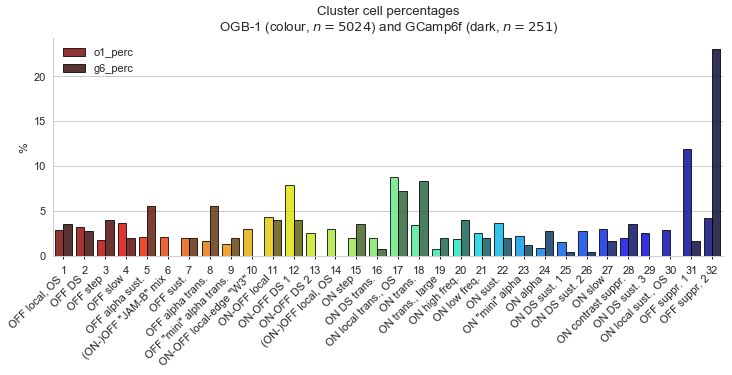

In [63]:
# Figure setup
rcParams['figure.figsize'] = [8.0, 8.0]
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(12,4))

# Color map for OGB1-groups/clusters - define plot-wise for better control
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.7)[::-1] # Create actual [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.9 # adjust cmap lightness (0.8)

sns.barplot(data=cpc2, x='groupIdx', y='cpc_perc', 
            hue='dataset', hue_order=['o1_perc', 'g6_perc'], edgecolor='k', linewidth=1, alpha=0.8) 
# Figure post-setup
ax.set(
    title = 'Cluster cell percentages'\
            '\n OGB-1 (colour, $n=%d$) and GCamp6f (dark, $n=%d$)'
            %(sum(ogb1['chirpN'][0]), len(gcamp6)),
    xlabel = '',
    ylabel = '%',
#     xticks = np.arange(4, p['nOgb1Groups'], 5), # Note: tick 4 > ticklabel 5
#     xticklabels = np.arange(5, p['nOgb1Groups'], 5), # Note: need to set this too to align ticks and ticklabels!
    xticklabels = np.arange(1, p['nOgb1Groups']+1, 1), # Note: need to set this too to align ticks and ticklabels!
    )
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax.tick_params(axis='x', which='major', length=3.) # sns.set_style({'xtick.major.size':'0.0'})
ax.tick_params(axis='x', which='minor', length=2.)

## Change grouped barplot bar colors
# A bit of a trick that requires a colormap spanning both gcamp6 and ogb1 groups
# and applies each color to a single bar patch object
cmapDark = cmap*0.4+[0,0,0,0.4]
cmap2 = np.concatenate((cmap,cmapDark))
for j, bar in enumerate(ax.patches):
    bar.set_color(cmap2[j,:])
    bar.set_edgecolor([0,0,0,1])
    
plt.legend(loc=0)

## Add 2nd axis with clu/group labels
# Use clu or group labels
if p['plotCluVGroup'] == 'Clu':
    labels = cluIDs
elif p['plotCluVGroup'] == 'Group':
    labels = groupIDs
ax2 = ax.twiny() # Create twin axis
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes',-0.05)) # Offset ax2
ax2.set_frame_on(False)
ax2.set(
    xlim = ax.get_xlim(), # Align ax2 and ax x-axis (important)
    xticks = ax.get_xticks(),
    xticklabels = labels,
    )
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax2.grid(False)

# Figure post setup
sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.show()

# Save figure
# plt.savefig('../../results/figs/cells_per_cluGroup/cpc_g6_only.eps', dpi=1200)

## Test cell-per-cluster/group significance
permutation test: allocate gcamp6 cells randomly to ogb1 clusters based on ogb1-cell-per-cluster percentages
TODO: This is just a binomial test - implement it as indicated on white board.

In [64]:
cpc

color  g6_n    g6_perc  \
0                                [0.4, 0.0, 0.0, 0.8]     9   3.585657   
1                     [0.514081996435, 0.0, 0.0, 0.8]     7   2.788845   
2                      [0.62816399287, 0.0, 0.0, 0.8]    10   3.984064   
3         [0.742245989305, 0.0122004357298, 0.0, 0.8]     5   1.992032   
4                     [0.8, 0.116775599129, 0.0, 0.8]    14   5.577689   
5                     [0.8, 0.209731299927, 0.0, 0.8]     0   0.000000   
6                     [0.8, 0.302687000726, 0.0, 0.8]     5   1.992032   
7                     [0.8, 0.395642701525, 0.0, 0.8]    14   5.577689   
8                     [0.8, 0.500217864924, 0.0, 0.8]     5   1.992032   
9                     [0.8, 0.593173565723, 0.0, 0.8]     0   0.000000   
10                    [0.8, 0.686129266521, 0.0, 0.8]    10   3.984064   
11  [0.76660341556, 0.77908496732, 0.0075901328273...    10   3.984064   
12        [0.675521821632, 0.8, 0.0986717267552, 0.8]     0   0.000000   
13          [0.594560404807, 0.8, 0.17963314358, 0.8]     0   0.000000   
14         [0.513598987982, 0.8, 0.260594560405, 0.8]     9   3.585657   
15          [0.432637571157, 0.8, 0.34155597723, 0.8]     2   0.796813   
16          [0.34155597723, 0.8, 0.432637571157, 0.8]    18   7.171315   
17         [0.260594560405, 0.8, 0.513598987982, 0.8]    21   8.366534   
18          [0.17963314358, 0.8, 0.594560404807, 0.8]     5   1.992032   
19        [0.0986717267552, 0.8, 0.675521821632, 0.8]    10   3.984064   
20  [0.00759013282732, 0.729411764706, 0.766603415...     5   1.992032   
21                    [0.0, 0.629019607843, 0.8, 0.8]     5   1.992032   
22                     [0.0, 0.52862745098, 0.8, 0.8]     3   1.195219   
23                    [0.0, 0.428235294118, 0.8, 0.8]     7   2.788845   
24                    [0.0, 0.315294117647, 0.8, 0.8]     1   0.398406   
25                    [0.0, 0.214901960784, 0.8, 0.8]     1   0.398406   
26                    [0.0, 0.114509803922, 0.8, 0.8]     4   1.593625   
27                   [0.0, 0.0141176470588, 0.8, 0.8]     9   3.585657   
28                    [0.0, 0.0, 0.742245989305, 0.8]     0   0.000000   
29                     [0.0, 0.0, 0.62816399287, 0.8]     0   0.000000   
30                    [0.0, 0.0, 0.514081996435, 0.8]     4   1.593625   
31                               [0.0, 0.0, 0.4, 0.8]    58  23.107570   

    groupIdx  o1_n    o1_perc  
0          0   143   2.846338  
1          1   162   3.224522  
2          2    86   1.711783  
3          3   186   3.702229  
4          4   103   2.050159  
5          5   104   2.070064  
6          6   100   1.990446  
7          7    80   1.592357  
8          8    68   1.353503  
9          9   149   2.965764  
10        10   217   4.319268  
11        11   397   7.902070  
12        12   129   2.567675  
13        13   150   2.985669  
14        14    97   1.930732  
15        15    99   1.970541  
16        16   439   8.738057  
17        17   171   3.403662  
18        18    36   0.716561  
19        19    95   1.890924  
20        20   125   2.488057  
21        21   183   3.642516  
22        22   113   2.249204  
23        23    44   0.875796  
24        24    76   1.512739  
25        25   141   2.806529  
26        26   152   3.025478  
27        27   100   1.990446  
28        28   130   2.587580  
29        29   143   2.846338  
30        30   596  11.863057  
31        31   210   4.179936

In [66]:
## Get cluster range for each cluster within [0, 1]
# e.g. if ogb1-clu1 has 0.3, then it's range is 0-0.3, and if ogb1-clu2 has 0.1, then its range is 0.3-0.4 etc.
clu_intvls = np.cumsum(np.array(cpc['o1_perc'])) / 100 # express cluster range [0,1] as cumsum
clu_intvls = np.concatenate((np.array([0]), np.array(clu_intvls[0:-1]))) # shift array to get lower left bound for every cluster
clu_intvls

array([ 0.   ,  0.028,  0.061,  0.078,  0.115,  0.135,  0.156,  0.176,
        0.192,  0.205,  0.235,  0.278,  0.357,  0.383,  0.413,  0.432,
        0.452,  0.539,  0.573,  0.58 ,  0.599,  0.624,  0.661,  0.683,
        0.692,  0.707,  0.735,  0.765,  0.785,  0.811,  0.84 ,  0.958])

In [67]:
## Create artificial random distribution of gcamp6 cells per cluster
# NOTE: Dimitry pointed out that this can be achieved more simply by sampling from a binomial, 
# which would also give p-values more easily. Also, we could use Fisher's exact test in scipy.

nRep = 10000 # Repeat k times
cells_per_clu_rand = np.zeros((nRep, len(clu_intvls))) # initialize distribution var
cpc_rand_perc = np.zeros((nRep, len(clu_intvls))) # initialize distribution var

for k in range(nRep):
    # Create random uniform value for each g6 cell
    rand = np.random.rand(len(gcamp6))

    # Assign each g6 cell to a cluster based on random value
    rand_clu = np.zeros(len(rand), dtype=int) # initialize
    for i in range(len(rand)):
        rand_clu[i] = np.where(clu_intvls < rand[i])[0][-1]

    # Count n of occurences of cells per each cluster
    cells_per_clu_rand[k] = np.bincount(rand_clu, minlength=len(clu_intvls))

    # Convert to percentages
    cpc_rand_perc[k] = pop.percentage(cells_per_clu_rand[k], sum(cells_per_clu_rand[k]))

# Add to df
cpc = cpc.assign(o1_art_perc=np.mean(cpc_rand_perc, axis=0))

In [68]:
## Test significance of actual gcamp6 cell per cluster percentages based on artificial OGB-1 distribution

# Get percentile scores of actual gcamp6 cell distribution
cpc_g6_prctile = np.zeros(len(cpc['g6_perc']))
for i,val in enumerate(cpc.g6_perc):
#     print(i.Index, i.cpc_perc)
    cpc_g6_prctile[i] = scipy.stats.percentileofscore(cpc_rand_perc[:,i], val)
print(cpc_g6_prctile)

# Test significance: two-tailed
p['alpha'] = 0.01 # Significance lvl
cpc_g6_signif = (cpc_g6_prctile > 100-(p['alpha']*100)/2) | (cpc_g6_prctile < (p['alpha']*100)/2)
print(cpc_g6_signif)

# cpc_signif = \ # alternative code
# (np.array(cpc.cpc_perc[cpc.dataset=='g6_perc']) > np.percentile(cpc_rand_perc, 95, axis=0)) | \
# (np.array(cpc.cpc_perc[cpc.dataset=='g6_perc']) < np.percentile(cpc_rand_perc, 5, axis=0))

# Add to df
cpc = cpc.assign(g6_prctile=cpc_g6_prctile)
cpc = cpc.assign(g6_signif=cpc_g6_signif)

[  76.81    37.43    99.21     6.85    99.975    0.21    52.96   100.
   80.42     0.035   41.085    0.62     0.06     0.05    95.905    8.29
   19.13    99.98    97.685   98.32    32.535    7.43    12.755   99.43
    6.675    0.395    8.995   95.395    0.075    0.055    0.     100.   ]
[False False False False  True  True False  True False  True False False
  True  True False False False  True False False False False False False
 False  True False False  True  True  True  True]


In [69]:
## Convert percentiles into p-values (two-tailed)
# TODO: this is not two-tailed, but a picky one-tailed test! Change (or just use binomial test)!
g6_pvals = np.zeros(len(cpc['g6_perc']))
for i,val in enumerate(cpc.g6_prctile):
    if val > 50: # Convert percentiles > 50 into 100-percentile for two-tailed p-values
        g6_pvals[i] = 1 - (val/100) 
    elif val < 50:
        g6_pvals[i] = val/100

# Correct p-values for 0 or 100 percentiles to p-value we can safely assume based on the number of repetitions
g6_pvals[g6_pvals==0] = 1/nRep
print(g6_pvals)

[ 0.232  0.374  0.008  0.069  0.     0.002  0.47   0.     0.196  0.     0.411
  0.006  0.001  0.001  0.041  0.083  0.191  0.     0.023  0.017  0.325
  0.074  0.128  0.006  0.067  0.004  0.09   0.046  0.001  0.001  0.     0.   ]


In [70]:
## Correct for multiple comparisons using False Discovery Rate (FDR)

import statsmodels.stats.multitest as smm

[reject_null, pvals_corr, _, _] = smm.multipletests(g6_pvals, p['alpha'], method='fdr_bh') # 'fdr_bh' = FDF-Benjamini/Hochberg
print(reject_null)
print(pvals_corr)

# Add to df
cpc = cpc.assign(g6_pval_corr=pvals_corr)
cpc = cpc.assign(g6_signif_corr=reject_null)

[False False False False  True  True False  True False  True False False
  True  True False False False  True False False False False False False
 False False False False  True  True  True  True]
[ 0.265  0.399  0.017  0.104  0.002  0.006  0.47   0.001  0.232  0.002
  0.424  0.014  0.002  0.002  0.073  0.115  0.232  0.002  0.044  0.034
  0.359  0.108  0.163  0.014  0.104  0.011  0.12   0.078  0.002  0.002
  0.001  0.001]


# TEST binom

In [71]:
cpc

color  g6_n    g6_perc  \
0                                [0.4, 0.0, 0.0, 0.8]     9   3.585657   
1                     [0.514081996435, 0.0, 0.0, 0.8]     7   2.788845   
2                      [0.62816399287, 0.0, 0.0, 0.8]    10   3.984064   
3         [0.742245989305, 0.0122004357298, 0.0, 0.8]     5   1.992032   
4                     [0.8, 0.116775599129, 0.0, 0.8]    14   5.577689   
5                     [0.8, 0.209731299927, 0.0, 0.8]     0   0.000000   
6                     [0.8, 0.302687000726, 0.0, 0.8]     5   1.992032   
7                     [0.8, 0.395642701525, 0.0, 0.8]    14   5.577689   
8                     [0.8, 0.500217864924, 0.0, 0.8]     5   1.992032   
9                     [0.8, 0.593173565723, 0.0, 0.8]     0   0.000000   
10                    [0.8, 0.686129266521, 0.0, 0.8]    10   3.984064   
11  [0.76660341556, 0.77908496732, 0.0075901328273...    10   3.984064   
12        [0.675521821632, 0.8, 0.0986717267552, 0.8]     0   0.000000   
13          [0.594560404807, 0.8, 0.17963314358, 0.8]     0   0.000000   
14         [0.513598987982, 0.8, 0.260594560405, 0.8]     9   3.585657   
15          [0.432637571157, 0.8, 0.34155597723, 0.8]     2   0.796813   
16          [0.34155597723, 0.8, 0.432637571157, 0.8]    18   7.171315   
17         [0.260594560405, 0.8, 0.513598987982, 0.8]    21   8.366534   
18          [0.17963314358, 0.8, 0.594560404807, 0.8]     5   1.992032   
19        [0.0986717267552, 0.8, 0.675521821632, 0.8]    10   3.984064   
20  [0.00759013282732, 0.729411764706, 0.766603415...     5   1.992032   
21                    [0.0, 0.629019607843, 0.8, 0.8]     5   1.992032   
22                     [0.0, 0.52862745098, 0.8, 0.8]     3   1.195219   
23                    [0.0, 0.428235294118, 0.8, 0.8]     7   2.788845   
24                    [0.0, 0.315294117647, 0.8, 0.8]     1   0.398406   
25                    [0.0, 0.214901960784, 0.8, 0.8]     1   0.398406   
26                    [0.0, 0.114509803922, 0.8, 0.8]     4   1.593625   
27                   [0.0, 0.0141176470588, 0.8, 0.8]     9   3.585657   
28                    [0.0, 0.0, 0.742245989305, 0.8]     0   0.000000   
29                     [0.0, 0.0, 0.62816399287, 0.8]     0   0.000000   
30                    [0.0, 0.0, 0.514081996435, 0.8]     4   1.593625   
31                               [0.0, 0.0, 0.4, 0.8]    58  23.107570   

    groupIdx  o1_n    o1_perc  o1_art_perc  g6_prctile g6_signif  \
0          0   143   2.846338     2.839681      76.810     False   
1          1   162   3.224522     3.210279      37.430     False   
2          2    86   1.711783     1.706016      99.210     False   
3          3   186   3.702229     3.717729       6.850     False   
4          4   103   2.050159     2.055538      99.975      True   
5          5   104   2.070064     2.066295       0.210      True   
6          6   100   1.990446     1.992789      52.960     False   
7          7    80   1.592357     1.584821     100.000      True   
8          8    68   1.353503     1.358924      80.420     False   
9          9   149   2.965764     2.982868       0.035      True   
10        10   217   4.319268     4.331315      41.085     False   
11        11   397   7.902070     7.906892       0.620     False   
12        12   129   2.567675     2.556175       0.060      True   
13        13   150   2.985669     2.983665       0.050      True   
14        14    97   1.930732     1.922948      95.905     False   
15        15    99   1.970541     1.977012       8.290     False   
16        16   439   8.738057     8.725378      19.130     False   
17        17   171   3.403662     3.387052      99.980      True   
18        18    36   0.716561     0.717888      97.685     False   
19        19    95   1.890924     1.907052      98.320     False   
20        20   125   2.488057     2.496693      32.535     False   
21        21   183   3.642516     3.637769       7.430     False   
22        22   113   2.249204     2.25625

In [72]:
n, prob = 10, 0.5
np.random.binomial(n, prob, 10)

array([3, 5, 7, 3, 5, 2, 7, 3, 5, 5])

In [73]:
np.random.binomial(251, 0.0285, 100)

array([ 6,  7,  8,  6,  4,  7,  6,  7,  3,  4,  4,  7, 12,  9,  5,  6, 10,
        9,  3,  7,  2, 10,  4,  3,  5,  6,  9,  8,  5,  5,  7, 13,  4, 13,
       12,  4,  4,  8,  8, 11,  5,  8, 11,  6,  4,  6,  7,  5,  4, 10,  7,
        5,  3,  6,  8,  8,  6, 11,  4,  8,  8, 10, 11, 12,  6,  9,  9,  7,
        9,  8,  4, 11,  5,  7,  8, 11,  4, 10,  9,  2,  7, 11, 11,  8,  8,
       11,  5,  6,  5,  7,  7,  8,  6,  7,  7,  8, 11, 12,  7, 12])

In [74]:
stats.binom.ppf(0.01, n, prob)

1.0

In [75]:
x = np.arange(stats.binom.ppf(0.01, n, prob), stats.binom.ppf(0.99, n, prob))

In [76]:
x

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

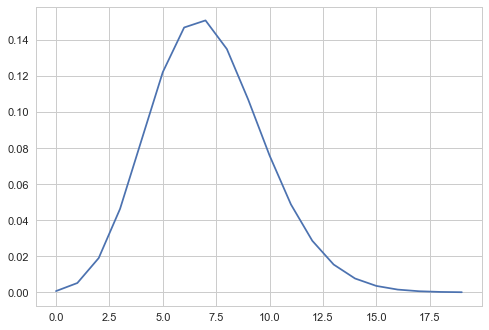

In [77]:
prob = 0.0285
n = 251
x = np.arange(0,20)

rv = stats.binom(n, prob)
plt.plot(x, stats.binom.pmf(x, n, prob))
# ax.vlines(x, 0, stats.binom.pmf(x, n, prob))
plt.show()

In [78]:
# Get probability of single value
k = 9
print(stats.binom.pmf(k, n, prob))

# same thing
print(sum(np.random.binomial(n, prob, 10000) == 9)/10000)


0.106919890277
0.1092


### Test significance

In [79]:
# One-tailed test
print(sum(np.random.binomial(n, prob, 10000) >= 9)/10000)

hi_p = stats.binom_test(9, 251, prob, alternative='greater') # same
print(hi_p)

lo = np.mean(cells_per_clu_rand[:,0]) + (np.mean(cells_per_clu_rand[:,0]) - k)
lo_p = stats.binom_test(lo, 251, prob, alternative='less')
print(lo_p)

print(hi_p + lo_p)

0.2884
0.289480521162
0.277732996973
0.567213518135


In [80]:
lo

5.2552000000000003

In [81]:
# Two-tailed test
stats.binom_test(9, 251, prob, alternative='two-sided') # seems same as rounding lo down to '4' rather than 5

0.44505189919852156

In [82]:
cpc

color  g6_n    g6_perc  \
0                                [0.4, 0.0, 0.0, 0.8]     9   3.585657   
1                     [0.514081996435, 0.0, 0.0, 0.8]     7   2.788845   
2                      [0.62816399287, 0.0, 0.0, 0.8]    10   3.984064   
3         [0.742245989305, 0.0122004357298, 0.0, 0.8]     5   1.992032   
4                     [0.8, 0.116775599129, 0.0, 0.8]    14   5.577689   
5                     [0.8, 0.209731299927, 0.0, 0.8]     0   0.000000   
6                     [0.8, 0.302687000726, 0.0, 0.8]     5   1.992032   
7                     [0.8, 0.395642701525, 0.0, 0.8]    14   5.577689   
8                     [0.8, 0.500217864924, 0.0, 0.8]     5   1.992032   
9                     [0.8, 0.593173565723, 0.0, 0.8]     0   0.000000   
10                    [0.8, 0.686129266521, 0.0, 0.8]    10   3.984064   
11  [0.76660341556, 0.77908496732, 0.0075901328273...    10   3.984064   
12        [0.675521821632, 0.8, 0.0986717267552, 0.8]     0   0.000000   
13          [0.594560404807, 0.8, 0.17963314358, 0.8]     0   0.000000   
14         [0.513598987982, 0.8, 0.260594560405, 0.8]     9   3.585657   
15          [0.432637571157, 0.8, 0.34155597723, 0.8]     2   0.796813   
16          [0.34155597723, 0.8, 0.432637571157, 0.8]    18   7.171315   
17         [0.260594560405, 0.8, 0.513598987982, 0.8]    21   8.366534   
18          [0.17963314358, 0.8, 0.594560404807, 0.8]     5   1.992032   
19        [0.0986717267552, 0.8, 0.675521821632, 0.8]    10   3.984064   
20  [0.00759013282732, 0.729411764706, 0.766603415...     5   1.992032   
21                    [0.0, 0.629019607843, 0.8, 0.8]     5   1.992032   
22                     [0.0, 0.52862745098, 0.8, 0.8]     3   1.195219   
23                    [0.0, 0.428235294118, 0.8, 0.8]     7   2.788845   
24                    [0.0, 0.315294117647, 0.8, 0.8]     1   0.398406   
25                    [0.0, 0.214901960784, 0.8, 0.8]     1   0.398406   
26                    [0.0, 0.114509803922, 0.8, 0.8]     4   1.593625   
27                   [0.0, 0.0141176470588, 0.8, 0.8]     9   3.585657   
28                    [0.0, 0.0, 0.742245989305, 0.8]     0   0.000000   
29                     [0.0, 0.0, 0.62816399287, 0.8]     0   0.000000   
30                    [0.0, 0.0, 0.514081996435, 0.8]     4   1.593625   
31                               [0.0, 0.0, 0.4, 0.8]    58  23.107570   

    groupIdx  o1_n    o1_perc  o1_art_perc  g6_prctile g6_signif  \
0          0   143   2.846338     2.839681      76.810     False   
1          1   162   3.224522     3.210279      37.430     False   
2          2    86   1.711783     1.706016      99.210     False   
3          3   186   3.702229     3.717729       6.850     False   
4          4   103   2.050159     2.055538      99.975      True   
5          5   104   2.070064     2.066295       0.210      True   
6          6   100   1.990446     1.992789      52.960     False   
7          7    80   1.592357     1.584821     100.000      True   
8          8    68   1.353503     1.358924      80.420     False   
9          9   149   2.965764     2.982868       0.035      True   
10        10   217   4.319268     4.331315      41.085     False   
11        11   397   7.902070     7.906892       0.620     False   
12        12   129   2.567675     2.556175       0.060      True   
13        13   150   2.985669     2.983665       0.050      True   
14        14    97   1.930732     1.922948      95.905     False   
15        15    99   1.970541     1.977012       8.290     False   
16        16   439   8.738057     8.725378      19.130     False   
17        17   171   3.403662     3.387052      99.980      True   
18        18    36   0.716561     0.717888      97.685     False   
19        19    95   1.890924     1.907052      98.320     False   
20        20   125   2.488057     2.496693      32.535     False   
21        21   183   3.642516     3.637769       7.430     False   
22        22   113   2.249204     2.25625

In [83]:
i = 0
cpc['o1_perc'][i]

2.8463379999999998

In [84]:
pvals = np.zeros(len(cpc['g6_perc']))

for i, val in enumerate(cpc['g6_n']):
    prob = cpc['o1_perc'][i]*0.01
#     print(i, val, prob)
    pvals[i] = stats.binom_test(val, 251, prob, alternative='two-sided') # seems same as rounding lo down to '4' rather than 5
    
print(pvals)

[ 0.445  0.858  0.012  0.18   0.001  0.012  1.     0.     0.4    0.001  1.
  0.019  0.002  0.001  0.064  0.252  0.434  0.     0.036  0.031  0.838
  0.234  0.389  0.007  0.195  0.012  0.264  0.105  0.002  0.002  0.     0.   ]


In [85]:
## Correct for multiple comparisons using False Discovery Rate (FDR)

import statsmodels.stats.multitest as smm

[reject_null, pvals_corr, _, _] = smm.multipletests(pvals, p['alpha'], method='fdr_bh') # 'fdr_bh' = FDF-Benjamini/Hochberg
print(reject_null)
print(pvals_corr)

# # Add to df
# cpc = cpc.assign(g6_pval_corr=pvals_corr)
# cpc = cpc.assign(g6_signif_corr=reject_null)

[False False False False  True False False  True False  True False False
  True  True False False False  True False False False False False False
 False False False False  True  True  True  True]
[ 0.508  0.915  0.028  0.289  0.005  0.028  1.     0.001  0.492  0.005  1.
  0.04   0.008  0.005  0.114  0.351  0.508  0.001  0.067  0.061  0.915
  0.34   0.492  0.021  0.297  0.028  0.352  0.177  0.008  0.007  0.     0.   ]


In [86]:
for i, val in enumerate(pvals):
    print('%i %.3f %.3f' % (i, g6_pval[i], pvals[i]))

NameError: name 'g6_pval' is not defined

In [87]:
cpc

color  g6_n    g6_perc  \
0                                [0.4, 0.0, 0.0, 0.8]     9   3.585657   
1                     [0.514081996435, 0.0, 0.0, 0.8]     7   2.788845   
2                      [0.62816399287, 0.0, 0.0, 0.8]    10   3.984064   
3         [0.742245989305, 0.0122004357298, 0.0, 0.8]     5   1.992032   
4                     [0.8, 0.116775599129, 0.0, 0.8]    14   5.577689   
5                     [0.8, 0.209731299927, 0.0, 0.8]     0   0.000000   
6                     [0.8, 0.302687000726, 0.0, 0.8]     5   1.992032   
7                     [0.8, 0.395642701525, 0.0, 0.8]    14   5.577689   
8                     [0.8, 0.500217864924, 0.0, 0.8]     5   1.992032   
9                     [0.8, 0.593173565723, 0.0, 0.8]     0   0.000000   
10                    [0.8, 0.686129266521, 0.0, 0.8]    10   3.984064   
11  [0.76660341556, 0.77908496732, 0.0075901328273...    10   3.984064   
12        [0.675521821632, 0.8, 0.0986717267552, 0.8]     0   0.000000   
13          [0.594560404807, 0.8, 0.17963314358, 0.8]     0   0.000000   
14         [0.513598987982, 0.8, 0.260594560405, 0.8]     9   3.585657   
15          [0.432637571157, 0.8, 0.34155597723, 0.8]     2   0.796813   
16          [0.34155597723, 0.8, 0.432637571157, 0.8]    18   7.171315   
17         [0.260594560405, 0.8, 0.513598987982, 0.8]    21   8.366534   
18          [0.17963314358, 0.8, 0.594560404807, 0.8]     5   1.992032   
19        [0.0986717267552, 0.8, 0.675521821632, 0.8]    10   3.984064   
20  [0.00759013282732, 0.729411764706, 0.766603415...     5   1.992032   
21                    [0.0, 0.629019607843, 0.8, 0.8]     5   1.992032   
22                     [0.0, 0.52862745098, 0.8, 0.8]     3   1.195219   
23                    [0.0, 0.428235294118, 0.8, 0.8]     7   2.788845   
24                    [0.0, 0.315294117647, 0.8, 0.8]     1   0.398406   
25                    [0.0, 0.214901960784, 0.8, 0.8]     1   0.398406   
26                    [0.0, 0.114509803922, 0.8, 0.8]     4   1.593625   
27                   [0.0, 0.0141176470588, 0.8, 0.8]     9   3.585657   
28                    [0.0, 0.0, 0.742245989305, 0.8]     0   0.000000   
29                     [0.0, 0.0, 0.62816399287, 0.8]     0   0.000000   
30                    [0.0, 0.0, 0.514081996435, 0.8]     4   1.593625   
31                               [0.0, 0.0, 0.4, 0.8]    58  23.107570   

    groupIdx  o1_n    o1_perc  o1_art_perc  g6_prctile g6_signif  \
0          0   143   2.846338     2.839681      76.810     False   
1          1   162   3.224522     3.210279      37.430     False   
2          2    86   1.711783     1.706016      99.210     False   
3          3   186   3.702229     3.717729       6.850     False   
4          4   103   2.050159     2.055538      99.975      True   
5          5   104   2.070064     2.066295       0.210      True   
6          6   100   1.990446     1.992789      52.960     False   
7          7    80   1.592357     1.584821     100.000      True   
8          8    68   1.353503     1.358924      80.420     False   
9          9   149   2.965764     2.982868       0.035      True   
10        10   217   4.319268     4.331315      41.085     False   
11        11   397   7.902070     7.906892       0.620     False   
12        12   129   2.567675     2.556175       0.060      True   
13        13   150   2.985669     2.983665       0.050      True   
14        14    97   1.930732     1.922948      95.905     False   
15        15    99   1.970541     1.977012       8.290     False   
16        16   439   8.738057     8.725378      19.130     False   
17        17   171   3.403662     3.387052      99.980      True   
18        18    36   0.716561     0.717888      97.685     False   
19        19    95   1.890924     1.907052      98.320     False   
20        20   125   2.488057     2.496693      32.535     False   
21        21   183   3.642516     3.637769       7.430     False   
22        22   113   2.249204     2.25625

In [88]:
for i, val in enumerate(pvals):
    print('%i %.3f %.3f' % (i, cpc['g6_pval_corr'][i], pvals_corr[i]))

0 0.265 0.508
1 0.399 0.915
2 0.017 0.028
3 0.104 0.289
4 0.002 0.005
5 0.006 0.028
6 0.470 1.000
7 0.001 0.001
8 0.232 0.492
9 0.002 0.005
10 0.424 1.000
11 0.014 0.040
12 0.002 0.008
13 0.002 0.005
14 0.073 0.114
15 0.115 0.351
16 0.232 0.508
17 0.002 0.001
18 0.044 0.067
19 0.034 0.061
20 0.359 0.915
21 0.108 0.340
22 0.163 0.492
23 0.014 0.021
24 0.104 0.297
25 0.011 0.028
26 0.120 0.352
27 0.078 0.177
28 0.002 0.008
29 0.002 0.007
30 0.001 0.000
31 0.001 0.000


In [359]:
cpc.apply(lambda x: func(x), axis=0) # How to apply a function row-/column-wise to a pandas dataframe


color  g6_n    g6_perc  \
0                                [0.4, 0.0, 0.0, 0.8]     9   3.585657   
1                     [0.514081996435, 0.0, 0.0, 0.8]     7   2.788845   
2                      [0.62816399287, 0.0, 0.0, 0.8]    10   3.984064   
3         [0.742245989305, 0.0122004357298, 0.0, 0.8]     5   1.992032   
4                     [0.8, 0.116775599129, 0.0, 0.8]    14   5.577689   
5                     [0.8, 0.209731299927, 0.0, 0.8]     0   0.000000   
6                     [0.8, 0.302687000726, 0.0, 0.8]     5   1.992032   
7                     [0.8, 0.395642701525, 0.0, 0.8]    14   5.577689   
8                     [0.8, 0.500217864924, 0.0, 0.8]     5   1.992032   
9                     [0.8, 0.593173565723, 0.0, 0.8]     0   0.000000   
10                    [0.8, 0.686129266521, 0.0, 0.8]    10   3.984064   
11  [0.76660341556, 0.77908496732, 0.0075901328273...    10   3.984064   
12        [0.675521821632, 0.8, 0.0986717267552, 0.8]     0   0.000000   
13          [0.594560404807, 0.8, 0.17963314358, 0.8]     0   0.000000   
14         [0.513598987982, 0.8, 0.260594560405, 0.8]     9   3.585657   
15          [0.432637571157, 0.8, 0.34155597723, 0.8]     2   0.796813   
16          [0.34155597723, 0.8, 0.432637571157, 0.8]    18   7.171315   
17         [0.260594560405, 0.8, 0.513598987982, 0.8]    21   8.366534   
18          [0.17963314358, 0.8, 0.594560404807, 0.8]     5   1.992032   
19        [0.0986717267552, 0.8, 0.675521821632, 0.8]    10   3.984064   
20  [0.00759013282732, 0.729411764706, 0.766603415...     5   1.992032   
21                    [0.0, 0.629019607843, 0.8, 0.8]     5   1.992032   
22                     [0.0, 0.52862745098, 0.8, 0.8]     3   1.195219   
23                    [0.0, 0.428235294118, 0.8, 0.8]     7   2.788845   
24                    [0.0, 0.315294117647, 0.8, 0.8]     1   0.398406   
25                    [0.0, 0.214901960784, 0.8, 0.8]     1   0.398406   
26                    [0.0, 0.114509803922, 0.8, 0.8]     4   1.593625   
27                   [0.0, 0.0141176470588, 0.8, 0.8]     9   3.585657   
28                    [0.0, 0.0, 0.742245989305, 0.8]     0   0.000000   
29                     [0.0, 0.0, 0.62816399287, 0.8]     0   0.000000   
30                    [0.0, 0.0, 0.514081996435, 0.8]     4   1.593625   
31                               [0.0, 0.0, 0.4, 0.8]    58  23.107570   

    groupIdx  o1_n    o1_perc  o1_art_perc  g6_prctile g6_signif  \
0          0   143   2.846338     2.838924      76.675     False   
1          1   162   3.224522     3.224064      36.985     False   
2          2    86   1.711783     1.700000      99.150     False   
3          3   186   3.702229     3.692709       7.135     False   
4          4   103   2.050159     2.040916      99.965      True   
5          5   104   2.070064     2.082032       0.270      True   
6          6   100   1.990446     1.996653      52.100     False   
7          7    80   1.592357     1.614821     100.000      True   
8          8    68   1.353503     1.349761      80.930     False   
9          9   149   2.965764     2.968645       0.050      True   
10        10   217   4.319268     4.324502      41.590     False   
11        11   397   7.902070     7.927450       0.655     False   
12        12   129   2.567675     2.571355       0.060      True   
13        13   150   2.985669     3.001872       0.020      True   
14        14    97   1.930732     1.936972      95.690     False   
15        15    99   1.970541     1.986295       8.280     False   
16        16   439   8.738057     8.717570      19.445     False   
17        17   171   3.403662     3.414024     100.000      True   
18        18    36   0.716561     0.727012      97.635     False   
19        19    95   1.890924     1.890438      98.575     False   
20        20   125   2.488057     2.473864      33.615     False   
21        21   183   3.642516     3.641315       7.515     False   
22        22   113   2.249204     2.24115

In [89]:
# Make own two-tailed p-value score

mean = np.mean(cells_per_clu_rand[:,0])
print(mean)

k = 9
hi_perctl = scipy.stats.percentileofscore(cells_per_clu_rand[:,0], k)
print(hi_perctl)

low = mean + (mean - k) # get difference of score to mean and get lower bound
print(low)

lo_perctl = scipy.stats.percentileofscore(cells_per_clu_rand[:,0], low)
print(lo_perctl)

(100 - hi_perctl) + lo_perctl

7.1276
76.81
5.2552
27.99


51.179999999999993

In [220]:
cpc

color  g6_n    g6_perc  \
0                               [0.45, 0.0, 0.0, 0.7]     9   3.585657   
1                     [0.530213903743, 0.0, 0.0, 0.7]     7   2.788845   
2                     [0.610427807487, 0.0, 0.0, 0.7]    10   3.984064   
3                      [0.69064171123, 0.0, 0.0, 0.7]     3   1.195219   
4                     [0.786898395722, 0.0, 0.0, 0.7]     2   0.796813   
5         [0.867112299465, 0.0398692810458, 0.0, 0.7]     7   2.788845   
6                      [0.9, 0.10522875817, 0.0, 0.7]     0   0.000000   
7                     [0.9, 0.183660130719, 0.0, 0.7]     7   2.788845   
8                     [0.9, 0.249019607843, 0.0, 0.7]     0   0.000000   
9                     [0.9, 0.314379084967, 0.0, 0.7]     5   1.992032   
10                    [0.9, 0.392810457516, 0.0, 0.7]     3   1.195219   
11                    [0.9, 0.458169934641, 0.0, 0.7]    11   4.382470   
12                    [0.9, 0.523529411765, 0.0, 0.7]     5   1.992032   
13                    [0.9, 0.601960784314, 0.0, 0.7]     0   0.000000   
14                    [0.9, 0.667320261438, 0.0, 0.7]     2   0.796813   
15                    [0.9, 0.732679738562, 0.0, 0.7]     8   3.187251   
16                    [0.9, 0.811111111111, 0.0, 0.7]     7   2.788845   
17  [0.862428842505, 0.876470588235, 0.00853889943...     3   1.195219   
18          [0.8055028463, 0.9, 0.0654648956357, 0.7]     0   0.000000   
19         [0.737191650854, 0.9, 0.133776091082, 0.7]     0   0.000000   
20         [0.680265654649, 0.9, 0.190702087287, 0.7]     9   3.585657   
21         [0.623339658444, 0.9, 0.247628083491, 0.7]     2   0.796813   
22         [0.555028462998, 0.9, 0.315939278937, 0.7]     2   0.796813   
23         [0.498102466793, 0.9, 0.372865275142, 0.7]    15   5.976096   
24         [0.441176470588, 0.9, 0.429791271347, 0.7]     1   0.398406   
25         [0.372865275142, 0.9, 0.498102466793, 0.7]    20   7.968127   
26         [0.315939278937, 0.9, 0.555028462998, 0.7]     1   0.398406   
27         [0.259013282732, 0.9, 0.611954459203, 0.7]     5   1.992032   
28         [0.190702087287, 0.9, 0.680265654649, 0.7]    10   3.984064   
29         [0.133776091082, 0.9, 0.737191650854, 0.7]     5   1.992032   
30        [0.0768500948767, 0.9, 0.794117647059, 0.7]     0   0.000000   
31  [0.00853889943074, 0.820588235294, 0.862428842...     5   1.992032   
32                              [0.0, 0.75, 0.9, 0.7]     3   1.195219   
33                    [0.0, 0.679411764706, 0.9, 0.7]     7   2.788845   
34                    [0.0, 0.594705882353, 0.9, 0.7]     1   0.398406   
35                    [0.0, 0.524117647059, 0.9, 0.7]     1   0.398406   
36                    [0.0, 0.453529411765, 0.9, 0.7]     4   1.593625   
37                    [0.0, 0.368823529412, 0.9, 0.7]     6   2.390438   
38                    [0.0, 0.298235294118, 0.9, 0.7]     3   1.195219   
39                    [0.0, 0.227647058824, 0.9, 0.7]     0   0.000000   
40                    [0.0, 0.142941176471, 0.9, 0.7]     0   0.000000   
41                   [0.0, 0.0723529411765, 0.9, 0.7]     0   0.000000   
42                  [0.0, 0.00176470588235, 0.9, 0.7]     2   0.796813   
43                    [0.0, 0.0, 0.867112299465, 0.7]     0   0.000000   
44                    [0.0, 0.0, 0.786898395722, 0.7]     1   0.398406   
45                    [0.0, 0.0, 0.706684491979, 0.7]     1   0.398406   
46                    [0.0, 0.0, 0.610427807487, 0.7]     9   3.585657   
47                    [0.0, 0.0, 0.530213903743, 0.7]    39  15.537849   
48                              [0.0, 0.0, 0.45, 0.7]    10   3.984064   

    groupIdx  o1_n   o1_perc  o1_art_perc  g6_prctile g6_signif  
0          0   143  2.846338     2.852112      76.945     False  
1          1   162  3.224522     3.208207      37.000     False  
2          2    86  1.711783     1.708725      99.295     False  
3          3    50  0.995223     1.001514      65.060     False  
4          4   13

In [90]:
n * prob

10.491639360000001

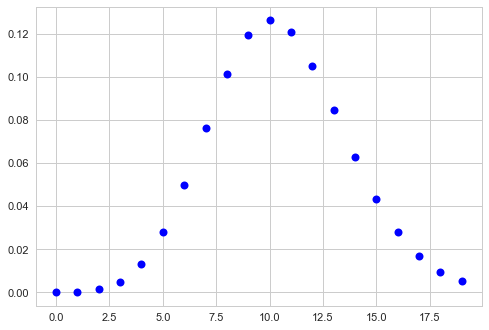

In [91]:
rv = stats.binom(n, prob)
x = np.arange(0, 20)

plt.plot(x, stats.binom.pmf(x, n, prob), 'bo', ms=8, label='binom pmf')

# ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
#         label='frozen pmf')
# ax.legend(loc='best', frameon=False)
# plt.show()

KeyError: 34

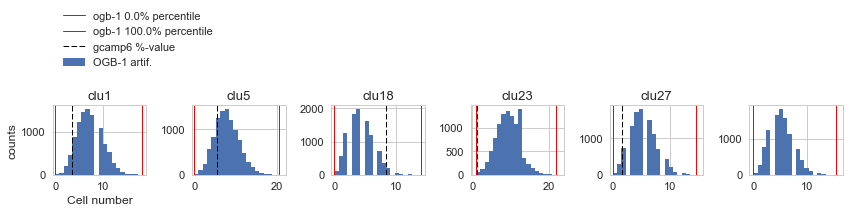

In [92]:
coi = np.array([1, 5, 18, 23, 27, 35])-1 # Clusters of interest (-1 for indexing)

# Figure presets
gs = gridspec.GridSpec(1, len(coi))#, width_ratios=[1,1])
rcParams['figure.figsize'] = 12,2

for i,val in enumerate(coi):
    plt.subplot(gs[0, i])
    
    # Draw artificial OGB1 histogram
    plt.hist(cells_per_clu_rand[:,i], bins=20, label='OGB-1 artif.')
    
    # Mark OGB-1 percentiles
    plt.axvline(np.percentile(cells_per_clu_rand[:,i], p['alpha']/2),
                label='ogb-1 %.1f%% percentile' %(p['alpha']/2), color='r', linewidth=1) # lower %ile
    plt.axvline(np.percentile(cells_per_clu_rand[:,i], 100-p['alpha']/2),
                label='ogb-1 %.1f%% percentile' %(100-p['alpha']/2), color='r', linewidth=1) # upper %ile
    
    # Mark gcamp6f value
    plt.axvline(cpc.g6_perc[val], label='gcamp6 %-value', color='k', linewidth=1, linestyle='dashed')
    
    # Figure post setup
    plt.gca().set(title = 'clu%i' %(val+1),
                  xlim = [-0.5, plt.gca().get_xlim()[1]])


    if i==0:
        plt.legend(loc='upper left', bbox_to_anchor=[0,2.5])
        plt.gca().set(
            xlabel = 'Cell number',
            ylabel = 'counts')

    plt.tight_layout()


(array([    9.,    52.,   196.,   463.,   865.,  1214.,  1441.,  1529.,
         1371.,     0.,  1081.,   710.,   535.,   263.,   152.,    69.,
           29.,    11.,     7.,     3.]),
 array([  0. ,   0.9,   1.8,   2.7,   3.6,   4.5,   5.4,   6.3,   7.2,
          8.1,   9. ,   9.9,  10.8,  11.7,  12.6,  13.5,  14.4,  15.3,
         16.2,  17.1,  18. ]),
 <a list of 20 Patch objects>)

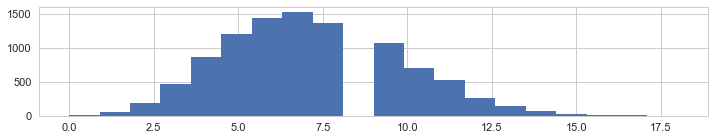

In [93]:
plt.hist(cells_per_clu_rand[:,0], bins=20, label='OGB-1 artif.')

(array([   10.,    46.,   116.,   260.,   511.,  1839.,  1131.,  1284.,
         1171.,  1089.,  1465.,   438.,   281.,   173.,    92.,    71.,
           15.,     6.,     0.,     2.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ,  14.2,  15.4,  16.6,  17.8,  19. ,  20.2,  21.4,
         22.6,  23.8,  25. ]),
 <a list of 20 Patch objects>)

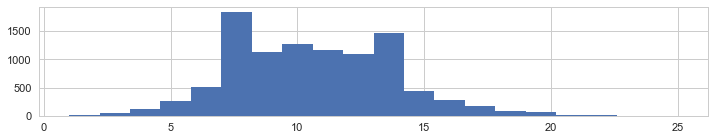

In [94]:
binom_sim = stats.binom.rvs(n, prob, size=10000)
plt.hist(binom_sim, bins=20, normed=False)

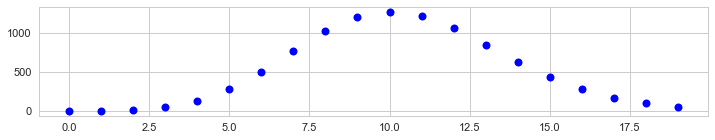

In [95]:
rv = stats.binom(n, prob)
x = np.arange(0, 20)

plt.plot(x, stats.binom.pmf(x, n, prob)*10000, 'bo', ms=8, label='binom pmf')

# ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
#         label='frozen pmf')
# ax.legend(loc='best', frameon=False)
# plt.show()

In [96]:
stats.binom.pmf(x, n, prob)*10000

array([    0.222,     2.426,    13.231,    47.904,   129.562,   279.201,
         499.36 ,   762.422,  1014.398,  1194.772,  1261.286,  1205.456,
        1051.706,   843.455,   625.496,   431.116,   277.396,   167.275,
          94.861,    50.746])

In [97]:
# stats.binom?

In [98]:
rv = stats.binom(n, p)
rv

TypeError: '>=' not supported between instances of 'dict' and 'int'

## Plot artificial OGB-1 cell distribution

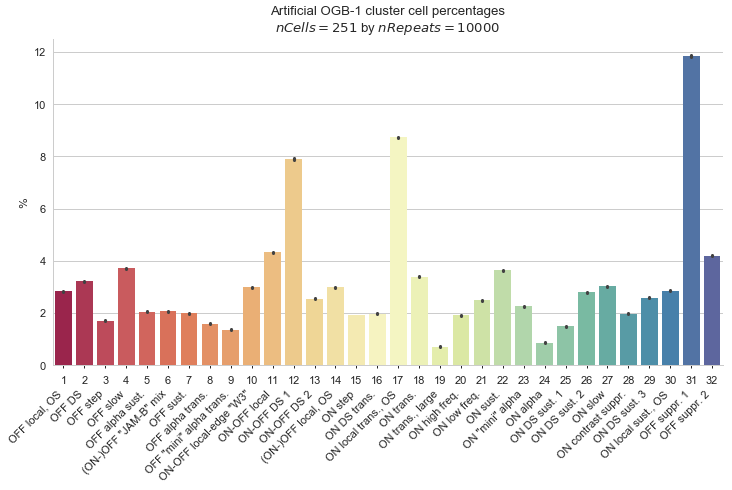

In [99]:
# Figure setup
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(12,6))

# Plot bars: mean and CI
sns.barplot(data=cpc_rand_perc, palette='Spectral') # NOTE: just using array [1000,49] here

# Plot gcamp6 distribution
# sns.barplot(data=cpc, x='groupIdx', y='cpc_perc', 
#             hue='dataset', hue_order=['g6_perc'], color='k', linewidth=1, alpha=0.7) 

# Figure post-setup
ax.set(
    title = 'Artificial OGB-1 cluster cell percentages'\
            '\n$nCells=%d$ by $nRepeats = %i$'
            %(len(gcamp6), nRep),
    xlabel = '',
    ylabel = '%',
#     xticks = np.arange(4, p['nOgb1Groups'], 5), # Note: tick 4 > ticklabel 5
#     xticklabels = np.arange(5, p['nOgb1Groups'], 5), # Note: need to set this too to align ticks and ticklabels!
    xticklabels = np.arange(1, p['nOgb1Groups']+1, 1), # Note: need to set this too to align ticks and ticklabels!
    )
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax.tick_params(axis='x', which='major', length=3.) # sns.set_style({'xtick.major.size':'0.0'})
ax.tick_params(axis='x', which='minor', length=2.)

## Add 2nd axis with clu/group labels
# Use clu or group labels
if p['plotCluVGroup'] == 'Clu':
    labels = cluIDs
elif p['plotCluVGroup'] == 'Group':
    labels = groupIDs
ax2 = ax.twiny() # Create twin axis
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes',-0.05)) # Offset ax2
ax2.set_frame_on(False)
ax2.set(
    xlim = ax.get_xlim(), # Align ax2 and ax x-axis (important)
    xticks = ax.get_xticks(),
    xticklabels = labels,
    )
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax2.grid(False)

# Figure post setup
sns.despine(top = True, right = True) # Remove unwanted axis borders

## Plot comparison of true OGB-1  vs. artificial OGB-1 cell distribution

In [100]:
# Bring some data from df from 'wide' into 'long' format for plot
cpc2 = pd.melt(cpc, id_vars=['groupIdx', 'color'], value_vars=['o1_perc', 'o1_art_perc'],
        var_name='dataset', value_name='cpc_perc')
cpc2

groupIdx                                              color      dataset  \
0          0                               [0.4, 0.0, 0.0, 0.8]      o1_perc   
1          1                    [0.514081996435, 0.0, 0.0, 0.8]      o1_perc   
2          2                     [0.62816399287, 0.0, 0.0, 0.8]      o1_perc   
3          3        [0.742245989305, 0.0122004357298, 0.0, 0.8]      o1_perc   
4          4                    [0.8, 0.116775599129, 0.0, 0.8]      o1_perc   
5          5                    [0.8, 0.209731299927, 0.0, 0.8]      o1_perc   
6          6                    [0.8, 0.302687000726, 0.0, 0.8]      o1_perc   
7          7                    [0.8, 0.395642701525, 0.0, 0.8]      o1_perc   
8          8                    [0.8, 0.500217864924, 0.0, 0.8]      o1_perc   
9          9                    [0.8, 0.593173565723, 0.0, 0.8]      o1_perc   
10        10                    [0.8, 0.686129266521, 0.0, 0.8]      o1_perc   
11        11  [0.76660341556, 0.77908496732, 0.0075901328273...      o1_perc   
12        12        [0.675521821632, 0.8, 0.0986717267552, 0.8]      o1_perc   
13        13          [0.594560404807, 0.8, 0.17963314358, 0.8]      o1_perc   
14        14         [0.513598987982, 0.8, 0.260594560405, 0.8]      o1_perc   
15        15          [0.432637571157, 0.8, 0.34155597723, 0.8]      o1_perc   
16        16          [0.34155597723, 0.8, 0.432637571157, 0.8]      o1_perc   
17        17         [0.260594560405, 0.8, 0.513598987982, 0.8]      o1_perc   
18        18          [0.17963314358, 0.8, 0.594560404807, 0.8]      o1_perc   
19        19        [0.0986717267552, 0.8, 0.675521821632, 0.8]      o1_perc   
20        20  [0.00759013282732, 0.729411764706, 0.766603415...      o1_perc   
21        21                    [0.0, 0.629019607843, 0.8, 0.8]      o1_perc   
22        22                     [0.0, 0.52862745098, 0.8, 0.8]      o1_perc   
23        23                    [0.0, 0.428235294118, 0.8, 0.8]      o1_perc   
24        24                    [0.0, 0.315294117647, 0.8, 0.8]      o1_perc   
25        25                    [0.0, 0.214901960784, 0.8, 0.8]      o1_perc   
26        26                    [0.0, 0.114509803922, 0.8, 0.8]      o1_perc   
27        27                   [0.0, 0.0141176470588, 0.8, 0.8]      o1_perc   
28        28                    [0.0, 0.0, 0.742245989305, 0.8]      o1_perc   
29        29                     [0.0, 0.0, 0.62816399287, 0.8]      o1_perc   
..       ...                                                ...          ...   
34         2                     [0.62816399287, 0.0, 0.0, 0.8]  o1_art_perc   
35         3        [0.742245989305, 0.0122004357298, 0.0, 0.8]  o1_art_perc   
36         4                    [0.8, 0.116775599129, 0.0, 0.8]  o1_art_perc   
37         5                    [0.8, 0.209731299927, 0.0, 0.8]  o1_art_perc   
38         6                    [0.8, 0.302687000726, 0.0, 0.8]  o1_art_perc   
39         7                    [0.8, 0.395642701525, 0.0, 0.8]  o1_art_perc   
40         8                    [0.8, 0.500217864924, 0.0, 0.8]  o1_art_perc   
41         9                    [0.8, 0.593173565723, 0.0, 0.8]  o1_art_perc   
42        10                    [0.8, 0.686129266521, 0.0, 0.8]  o1_art_perc   
43        11  [0.76660341556, 0.77908496732, 0.0075901328273...  o1_art_perc   
44        12        [0.675521821632, 0.8, 0.0986717267552, 0.8]  o1_art_perc   
45        13          [0.594560404807, 0.8, 0.17963314358, 0.8]  o1_art_perc   
46        14         [0.513598987982, 0.8, 0.260594560405, 0.8]  o1_art_perc   
47        15          [0.432637571157, 0.8, 0.34155597723, 0.8]  o1_art_perc   
48        16          [0.34155597723, 0.8, 0.432637571157, 0.8]  o1_art_perc   
49        17         [0.260594560405, 0.8, 0.513598987982, 0.8]  o1_art_perc   
50        18          [0.17963314358, 0.8, 0.594560404807, 0.8]  o1_art_perc   
51        19        [0.0986717267552, 0.8, 0.675521821632, 0.8]  o1_art_perc   
52  

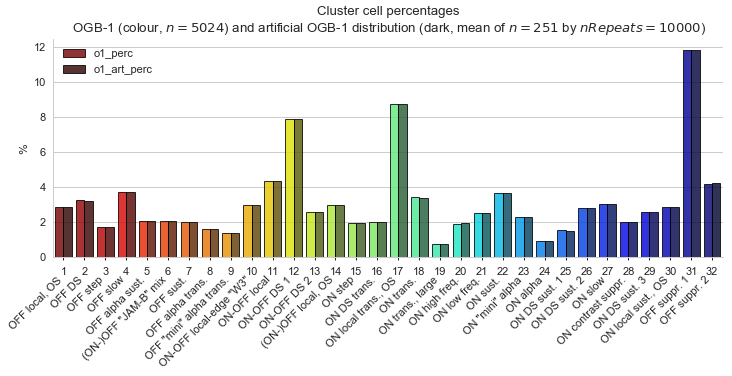

In [101]:
# Figure setup
rcParams['figure.figsize'] = [8.0, 8.0]
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(12,4))

# Color map for OGB1-groups/clusters - define plot-wise for better control
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.7)[::-1] # Create actual [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.9 # adjust cmap lightness (0.8)

sns.barplot(data=cpc2, x='groupIdx', y='cpc_perc', 
            hue='dataset', hue_order=['o1_perc', 'o1_art_perc'], edgecolor='k', linewidth=1, alpha=0.8) 

# Figure post-setup
ax.set(
    title = 'Cluster cell percentages'\
            '\n OGB-1 (colour, $n=%d$) and artificial OGB-1 distribution (dark, mean of $n=%d$ by $nRepeats = %i$)'
            %(sum(ogb1['chirpN'][0]), len(gcamp6), nRep),
    xlabel = '',
    ylabel = '%',
#     xticks = np.arange(4, p['nOgb1Groups'], 5), # Note: tick 4 > ticklabel 5
#     xticklabels = np.arange(5, p['nOgb1Groups'], 5), # Note: need to set this too to align ticks and ticklabels!
    xticklabels = np.arange(1, p['nOgb1Groups']+1, 1), # Note: need to set this too to align ticks and ticklabels!
    )
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax.tick_params(axis='x', which='major', length=3.) # sns.set_style({'xtick.major.size':'0.0'})
ax.tick_params(axis='x', which='minor', length=2.)

## Change grouped barplot bar colors
# A bit of a trick that requires a colormap spanning both gcamp6 and ogb1 groups
# and applies each color to a single bar patch object
cmapDark = cmap*0.4+[0,0,0,0.4]
cmap2 = np.concatenate((cmap,cmapDark))
for j, bar in enumerate(ax.patches):
    bar.set_color(cmap2[j,:])
    bar.set_edgecolor([0,0,0,1])
    
plt.legend(loc=0)

## Add 2nd axis with clu/group labels
# Use clu or group labels
if p['plotCluVGroup'] == 'Clu':
    labels = cluIDs
elif p['plotCluVGroup'] == 'Group':
    labels = groupIDs
ax2 = ax.twiny() # Create twin axis
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes',-0.05)) # Offset ax2
ax2.set_frame_on(False)
ax2.set(
    xlim = ax.get_xlim(), # Align ax2 and ax x-axis (important)
    xticks = ax.get_xticks(),
    xticklabels = labels,
    )
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax2.grid(False)

# Figure post setup
sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.show()

# Save figure
# plt.savefig('../../results/figs/cells_per_cluGroup/cpc_g6_only.eps', dpi=1200)

## Get number of cells per cluster as log2 ratios

In [102]:
## Regularize cell counts using additive / Laplace smoothing
# This is done here to avoid -inf values for gcamp6f clusters that did not get any cells assigned

def additive_smoothing(x, k=1):
    """Smoothes categorical data x by adding a pseudocount k and normalizing by n+k.
    INPUT:
    x : ndarray : Array of counts per category.
    k : scalar : Pseudocount. [DEFAULT: 1]
    
    OUTPUT:
    x_smooth : ndarray : Smoothed array.
    """
    k = 1 # Pseudocount k > 0
    x_smooth = (x + k) / (sum(x)+k)
    
    return x_smooth

In [103]:
# Smooth cell counts
cells_per_clu_g6_perc_smooth = additive_smoothing(cells_per_clu)*100 # Multiply by 100 to get percentage

cells_per_clu_o1_perc_smooth = additive_smoothing(ogb1['chirpN'][0])*100

In [104]:
# Also get Log2 ratio of gcamp6f vs ogb-1 cell percentages per cluster
cpc_perc_log2 = np.log2(cells_per_clu_g6_perc_smooth / cells_per_clu_o1_perc_smooth)
# cells_per_cluLog2[np.isinf(cells_per_cluLog2)] = -5 # Set inf values to arbitrary low value - workaround
cpc_perc_log2

array([ 0.47 , -0.031,  1.334, -0.644,  1.524, -2.397,  0.244,  1.885,
        0.794, -2.911,  0.009, -0.86 , -2.705, -2.921,  1.025, -0.741,
       -0.216,  1.351,  1.693,  1.192, -0.075, -0.621, -0.515,  1.826,
       -0.949, -1.832, -0.618,  0.981, -2.716, -2.852, -2.582,  2.479])

In [105]:
# Add log2 ratios to df
cpc = cpc.assign(log2=cpc_perc_log2)

## Plot cell distribution log2 ratios

In [106]:
rcParams['figure.autolayout'] = True

In [107]:
cpc

color  g6_n    g6_perc  \
0                                [0.4, 0.0, 0.0, 0.8]     9   3.585657   
1                     [0.514081996435, 0.0, 0.0, 0.8]     7   2.788845   
2                      [0.62816399287, 0.0, 0.0, 0.8]    10   3.984064   
3         [0.742245989305, 0.0122004357298, 0.0, 0.8]     5   1.992032   
4                     [0.8, 0.116775599129, 0.0, 0.8]    14   5.577689   
5                     [0.8, 0.209731299927, 0.0, 0.8]     0   0.000000   
6                     [0.8, 0.302687000726, 0.0, 0.8]     5   1.992032   
7                     [0.8, 0.395642701525, 0.0, 0.8]    14   5.577689   
8                     [0.8, 0.500217864924, 0.0, 0.8]     5   1.992032   
9                     [0.8, 0.593173565723, 0.0, 0.8]     0   0.000000   
10                    [0.8, 0.686129266521, 0.0, 0.8]    10   3.984064   
11  [0.76660341556, 0.77908496732, 0.0075901328273...    10   3.984064   
12        [0.675521821632, 0.8, 0.0986717267552, 0.8]     0   0.000000   
13          [0.594560404807, 0.8, 0.17963314358, 0.8]     0   0.000000   
14         [0.513598987982, 0.8, 0.260594560405, 0.8]     9   3.585657   
15          [0.432637571157, 0.8, 0.34155597723, 0.8]     2   0.796813   
16          [0.34155597723, 0.8, 0.432637571157, 0.8]    18   7.171315   
17         [0.260594560405, 0.8, 0.513598987982, 0.8]    21   8.366534   
18          [0.17963314358, 0.8, 0.594560404807, 0.8]     5   1.992032   
19        [0.0986717267552, 0.8, 0.675521821632, 0.8]    10   3.984064   
20  [0.00759013282732, 0.729411764706, 0.766603415...     5   1.992032   
21                    [0.0, 0.629019607843, 0.8, 0.8]     5   1.992032   
22                     [0.0, 0.52862745098, 0.8, 0.8]     3   1.195219   
23                    [0.0, 0.428235294118, 0.8, 0.8]     7   2.788845   
24                    [0.0, 0.315294117647, 0.8, 0.8]     1   0.398406   
25                    [0.0, 0.214901960784, 0.8, 0.8]     1   0.398406   
26                    [0.0, 0.114509803922, 0.8, 0.8]     4   1.593625   
27                   [0.0, 0.0141176470588, 0.8, 0.8]     9   3.585657   
28                    [0.0, 0.0, 0.742245989305, 0.8]     0   0.000000   
29                     [0.0, 0.0, 0.62816399287, 0.8]     0   0.000000   
30                    [0.0, 0.0, 0.514081996435, 0.8]     4   1.593625   
31                               [0.0, 0.0, 0.4, 0.8]    58  23.107570   

    groupIdx  o1_n    o1_perc  o1_art_perc  g6_prctile g6_signif  \
0          0   143   2.846338     2.839681      76.810     False   
1          1   162   3.224522     3.210279      37.430     False   
2          2    86   1.711783     1.706016      99.210     False   
3          3   186   3.702229     3.717729       6.850     False   
4          4   103   2.050159     2.055538      99.975      True   
5          5   104   2.070064     2.066295       0.210      True   
6          6   100   1.990446     1.992789      52.960     False   
7          7    80   1.592357     1.584821     100.000      True   
8          8    68   1.353503     1.358924      80.420     False   
9          9   149   2.965764     2.982868       0.035      True   
10        10   217   4.319268     4.331315      41.085     False   
11        11   397   7.902070     7.906892       0.620     False   
12        12   129   2.567675     2.556175       0.060      True   
13        13   150   2.985669     2.983665       0.050      True   
14        14    97   1.930732     1.922948      95.905     False   
15        15    99   1.970541     1.977012       8.290     False   
16        16   439   8.738057     8.725378      19.130     False   
17        17   171   3.403662     3.387052      99.980      True   
18        18    36   0.716561     0.717888      97.685     False   
19        19    95   1.890924     1.907052      98.320     False   
20        20   125   2.488057     2.496693      32.535     False   
21        21   183   3.642516     3.637769       7.430     False   
22        22   113   2.249204     2.25625

In [108]:
p

{'alpha': 0.01,
 'cluMethod': 'naive',
 'corrMethod': 'pearson',
 'doNormRho': False,
 'fidGcamp6': 'gcamp6Data_gcamp6fKern_7.8Hz.h5',
 'fidGcamp6Save': 'g6_assigned.mat',
 'fidOgb1Clu': 'BadenEtAl_RGCs_2016_ogb1_clu_ogb1Kern_7.8Hz.mat',
 'fidOgb1Group': 'BadenEtAl_RGCs_2016_ogb1_group_ogb1Kern_7.8Hz.mat',
 'groupVClu': 'Clu',
 'largeSomaLim': 136,
 'loadDir': '../../data/2P/proc/',
 'miCrit': 0,
 'miMethod': 'naive',
 'nOgb1Groups': 32,
 'plotCluVGroup': 'Group',
 'saveDir': '../../data/2P/proc/',
 'stim': ['chirp', 'bar']}

In [109]:
cpc.g6_pval_corr

0     0.265029
1     0.399253
2     0.016853
3     0.104381
4     0.001600
5     0.006109
6     0.470400
7     0.001067
8     0.232059
9     0.001867
10    0.424103
11    0.014171
12    0.002133
13    0.002133
14    0.072800
15    0.115339
16    0.232059
17    0.001600
18    0.043576
19    0.033600
20    0.359007
21    0.108073
22    0.163264
23    0.014031
24    0.104381
25    0.010533
26    0.119933
27    0.077558
28    0.002400
29    0.002133
30    0.001067
31    0.001067
Name: g6_pval_corr, dtype: float64

/Users/ybauer/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/ybauer/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


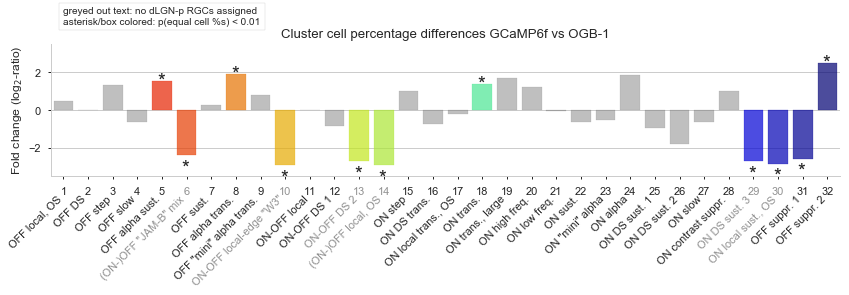

In [110]:
# Figure pars
p['doOwnCmap'] = True

# Figure setup
rcParams['figure.figsize'] = [8.0, 8.0]
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(12,4))

# Color map for OGB1-groups/clusters - define plot-wise for better control
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=0.7)[::-1] # Create actual [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.9 # adjust cmap lightness (0.8)

sns.barplot(data=cpc, x='groupIdx', y='log2', palette="Spectral")#, linewidth=1, edgecolor='k')

# Figure post-setup
ax.set(
    title = 'Cluster cell percentage differences GCaMP6f vs OGB-1',
    xlabel = '',
    ylabel = 'Fold change (log$_2$-ratio)' , #\n($log_2$(%dLGN-p RGCs/%RGC pop.))',
#     xticks = np.arange(4, p['nOgb1Groups'], 5), # Note: tick 4 > ticklabel 5
#     xticklabels = np.arange(5, p['nOgb1Groups'], 5), # Note: need to set this too to align ticks and ticklabels!
    xticklabels = np.arange(1, p['nOgb1Groups']+1, 1), # Note: need to set this too to align ticks and ticklabels!
    )
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax.tick_params(axis='x', which='major', length=3.) # sns.set_style({'xtick.major.size':'0.0'})
ax.tick_params(axis='x', which='minor', length=2.)
ax.tick_params(axis='y', which='major', length=3.)
ax.tick_params(axis='y', which='minor', length=2.)
ax.set_ylim([-3.5, 3.5])


# Change barplot bar colors
if p['doOwnCmap'] == True:
    # A bit of a trick that requires a colormap spanning both gcamp6 and ogb1 groups
    # and applies each color to a single bar patch object
    cmapDark = cmap*0.4+[0,0,0,0.4]
    cmap2 = np.concatenate((cmap,cmapDark))
    for j, bar in enumerate(ax.patches):
        bar.set_color(cmap2[j,:])
#         bar.set_edgecolor([0,0,0,1])
    
plt.legend(loc=0)

## Add 2nd axis with clu/group labels
# Use clu or group labels
if p['plotCluVGroup'] == 'Clu':
    labels = cluIDs
elif p['plotCluVGroup'] == 'Group':
    labels = groupIDs
ax2 = ax.twiny() # Create twin axis
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes',-0.08)) # Offset ax2
ax2.set_frame_on(False)
ax2.set(
    xlim = ax.get_xlim(), # Align ax2 and ax x-axis (important)
    xticks = ax.get_xticks(),
    xticklabels = labels,
    )
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right") # rotate xticklabels
ax2.grid(False)

## Mark clusters w no assigned gcamp6f cells: mark ticks transparent
for i,t in enumerate(ax.xaxis.get_ticklabels()): # mark numbers
    if cpc.g6_n[i] == 0:
        t.set_alpha(0.5)
        
for i,t in enumerate(ax2.xaxis.get_ticklabels()): # mark labels
    if cpc.g6_n[i] == 0:
        t.set_alpha(0.5)        
        
## Mark clusters w n=1 assigned cells
# for j, bar in enumerate(ax.patches):
#     if cpc['g6_n'][j] == 1:
#         ax.text(bar.get_x()+0.15, bar.get_y()+0.15, 'n = 1', 
#                 fontsize=10, horizontalalignment='left', verticalalignment='bottom', rotation=90)
        
## Mark significant g6 vs o1 differences
# for i,t in enumerate(ax.xaxis.get_ticklabels()): # mark numbers
#     if cpc.g6_signif[i] == 1:
#         t.set_color('red')
        
for i,bar in enumerate(ax.patches):
    # Adjust significance marker depending on lvl
    if cpc.g6_pval_corr[i] <= p['alpha']:
        txt = '*'
    if cpc.g6_pval_corr[i] <= p['alpha']/10:
        txt = '**'
    
    if (cpc.g6_signif_corr[i] == 1) & (np.isinf(cpc_perc_log2[i])): # set asterisks at x-axis for clusters with no cells
        ax.text(bar.get_x()+0.2, ax.get_ylim()[0], txt, # y:-3.6
                fontsize=20, horizontalalignment='left', verticalalignment='center')
#         if np.isinf(cpc_perc_log2[i]):
#             bar.set_linewidth(1)
    elif (cpc.g6_signif_corr[i] == 1) & (not np.isinf(cpc_perc_log2[i])): #g6_pval_corr
        if bar.get_y() >= 0:
            ax.text(bar.get_x()+0.2, bar.get_y()+bar.get_height(), txt, # y:-3.6
                    fontsize=20, horizontalalignment='left', verticalalignment='center')
        else:
            ax.text(bar.get_x()+0.2, bar.get_y()-0.7, txt, # y:-3.6
                    fontsize=20, horizontalalignment='left', verticalalignment='center')
    elif cpc.g6_signif_corr[i] == 0:
        bar.set_color('grey')
        bar.set_alpha(0.5)
#         bar.set_edgecolor('grey')

# Add info text
ax.text(0, 4.55, 
        'greyed out text: no dLGN-p RGCs assigned'\
#         '\nn=1: one cell assigned'\
        '\nasterisk/box colored: p(equal cell %s) < 0.01',
        fontsize=10, bbox={'facecolor':'white', 'edgecolor':'grey', 'alpha':0.5})
# ax.text(0, 3.8, 'n=1: one cell assigned', fontsize=10)
# ax.text(0, 3.1, 'asterisk: p(equal cell proportions) < 0.01', fontsize=10)

sns.despine(top = True, right = True) # Remove unwanted axis borders
# plt.show()

# plt.tight_layout()

# Save figure
plt.savefig('../../results/figs/cellPerCluGroup/cpc_kern_7.8Hz_log2.pdf', dpi=1200)

In [ ]:
cpc

## Check distributions for some non-significant high log2-ratio clusters

In [111]:
p = {}
p['alpha'] = 0.5

In [112]:
cpc_rand_perc.shape

(10000, 32)

KeyError: 34

/Users/ybauer/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


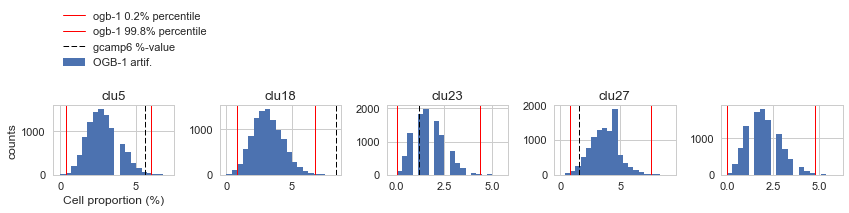

In [113]:
coi = np.array([5, 18, 23, 27, 35])-1 # Clusters of interest (-1 for indexing)

# Figure presets
gs = gridspec.GridSpec(1, len(coi))#, width_ratios=[1,1])
rcParams['figure.figsize'] = 12,2

for i,val in enumerate(coi):
    plt.subplot(gs[0, i])
    
    # Draw artificial OGB1 histogram
    plt.hist(cpc_rand_perc[:,i], bins=20, label='OGB-1 artif.')
    
    # Mark OGB-1 percentiles
    plt.axvline(np.percentile(cpc_rand_perc[:,i], p['alpha']/2),
                label='ogb-1 %.1f%% percentile' %(p['alpha']/2), color='r', linewidth=1) # lower %ile
    plt.axvline(np.percentile(cpc_rand_perc[:,i], 100-p['alpha']/2),
                label='ogb-1 %.1f%% percentile' %(100-p['alpha']/2), color='r', linewidth=1) # upper %ile
    
    # Mark gcamp6f value
    plt.axvline(cpc.g6_perc[val], label='gcamp6 %-value', color='k', linewidth=1, linestyle='dashed')
    
    # Figure post setup
    plt.gca().set(title = 'clu%i' %(val+1),
                  xlim = [-0.5, plt.gca().get_xlim()[1]])


    if i==0:
        plt.legend(loc='upper left', bbox_to_anchor=[0,2.5])
        plt.gca().set(
            xlabel = 'Cell proportion (%)',
            ylabel = 'counts')

    plt.tight_layout()


# Export gcamp6 data
Exports gcamp6 pandas dataframe (pd df) in various formats

In [125]:
# Save as pickled object
gcamp6.to_pickle(p['saveDir']+'g6_assigned.pkl')

In [128]:
## Export gcamp6 data to MATLAB
# Exports gcamp6 pandas dataframe (pd df) as .mat to MATLAB. Use workaround of converting df to dict before using scipy.io
# Convert pd df to dict

# Create [cell, time] array rather than single cells for each cell
g6_dict = {col_name : np.array(gcamp6[col_name].values.tolist()) for col_name in gcamp6.columns.values}

# Create cell arrays for cells
# g6_dict = {col_name : gcamp6[col_name].values for col_name in gcamp6.columns.values}

In [ ]:
# Save dict
print('Save to:', p['saveDir']+p['fidGcamp6Save'])
sio.savemat(p['saveDir']+p['fidGcamp6Save'], g6_dict) # Just save dict (> more crowded workspace)
# sio.savemat(p['saveDir']+p['fidGcamp6Save'], {'g6': g6_dict}) # Create single struct w data inside

In [34]:
# Inspect saved var
viewData = sio.whosmat(p['saveDir']+p['fidGcamp6Save'])
viewData

[('chirpDeconvSd', (251, 249), 'double'),
 ('barQiSortIdx', (1, 251), 'int64'),
 ('groupIdx', (1, 251), 'int64'),
 ('groupID', (251,), 'char'),
 ('roi', (1, 251), 'double'),
 ('chirpCorrSortIdx', (251, 49), 'int64'),
 ('miTotCellSortIdx', (1, 251), 'int64'),
 ('chirpTraces', (1, 251), 'cell'),
 ('chirpDeconvMean', (251, 249), 'double'),
 ('barMed', (251, 32), 'double'),
 ('barMean', (251, 32), 'double'),
 ('field', (251,), 'char'),
 ('mi', (251, 49), 'double'),
 ('dsPVal', (1, 251), 'double'),
 ('chirpQi', (1, 251), 'double'),
 ('barDeconvMean', (251, 32), 'double'),
 ('chirpSd', (251, 249), 'double'),
 ('miSortIdxClu', (251, 49), 'int64'),
 ('chirpCorrRho', (251, 49), 'double'),
 ('dsVector', (251, 8), 'double'),
 ('barTraces', (251, 24, 32), 'double'),
 ('dsi', (1, 251), 'double'),
 ('barMaxCorrs', (1, 251), 'double'),
 ('chirpMed', (251, 249), 'double'),
 ('maxMi', (1, 251), 'double'),
 ('barSd', (251, 32), 'double'),
 ('barQi', (1, 251), 'double'),
 ('barCorrRho', (251, 49), 'doubl

In [36]:
g2_load = sio.loadmat(p['saveDir']+p['fidGcamp6Save']) # Just save dict (> more crowded workspace)

In [37]:
g2_load

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Aug 14 17:27:27 2017',
 '__version__': '1.0',
 'barCondAvgTraces': array([[[ 0.009,  0.253,  0.289, ..., -0.479, -0.519, -0.614],
         [ 0.134,  0.06 , -0.11 , ..., -0.792, -0.899, -0.879],
         [ 0.012,  0.088, -0.193, ...,  0.577,  0.575,  0.571],
         ..., 
         [-0.012,  0.001,  0.09 , ...,  0.732,  0.452,  0.457],
         [ 0.01 , -0.02 ,  0.002, ...,  0.187,  0.188,  0.074],
         [-0.004,  0.006, -0.186, ..., -0.64 , -0.478, -0.574]],
 
        [[ 0.259,  0.031,  0.431, ...,  0.137, -0.078, -0.129],
         [-0.109,  0.041,  0.377, ...,  0.332, -0.147, -0.122],
         [ 0.21 ,  0.146, -0.08 , ..., -0.063,  0.255, -0.18 ],
         ..., 
         [-0.111, -0.024, -0.016, ...,  0.129,  0.455,  0.593],
         [ 0.841,  0.021,  0.037, ..., -0.107, -0.354,  0.133],
         [-0.271,  0.021,  0.226, ..., -0.386,  0.539,  0.461]],
 
        [[-0.011,  0.002,  0.006, ...,  

# Count number of recorded fields, cells and cells per field

In [67]:
nFieldsTot = 0 # Total nFields counter

for i in np.unique(gcamp6.date):
    print('date:', i)
    
    nFields = len(np.unique(gcamp6.field[gcamp6.date == i]))
    print(' nFields:', nFields)
    nFieldsTot += nFields
    
    nCells = len(gcamp6.roi[(gcamp6.date == i)])
    print(' nCells:', nCells)
    
    # nCells over all fields in date i
    nCellsPerField = nCells/nFields
    print(' nCellsPerField: %.1f' % np.round(nCellsPerField,1))
    
    # nCells for each field
#     for x in np.unique(gcamp6.field[gcamp6.date == i]):
#         cellsInField = len(gcamp6.roi[(gcamp6.date == i) & (gcamp6.field == x)])
#         print('  f%s: n=%i' % (x, cellsInField))
    
print('\nTotal nFields:', nFieldsTot)
print('Total nCells:', len(gcamp6))
print('Total nCellsPerField:', np.round(len(gcamp6)/nFieldsTot, 1))

date: 20160223
 nFields: 15
 nCells: 62
 nCellsPerField: 4.1
date: 20160224
 nFields: 12
 nCells: 34
 nCellsPerField: 2.8
date: 20160420
 nFields: 16
 nCells: 23
 nCellsPerField: 1.4
date: 20160421
 nFields: 25
 nCells: 132
 nCellsPerField: 5.3

Total nFields: 68
Total nCells: 251
Total nCellsPerField: 3.7


# TESTING PLAYGROUND

## Get data out of data frame

In [ ]:
# meta3['test'] = 's' # Set type to string avoids error - why?

### set up some mean array
# df row can contain multi-dim arrays, i.e. mutliple trials of a cell!
# We can also take mean of a given df row, i.e. mean over multiple trials (see below)
# metaD.set_value(0, 'mean', snippetsMean[:,0])
# metaD.set_value(1, 'mean', snippetsMean[:,1])

# metaD.set_value(1, 'test', np.array([0,1,3]))
# metaD.set_value(2, 'test', np.array(gcamp6ChirpMean2[:,0]))

# foo = meta3.loc[1, ('test')] # outputs a list
# meta3

#### get the stuff out
# mean = metaD.loc[0, ('mean')] # outputs original datatype
# mean = metaD.loc[0:2, ('mean')] # outputs a series
# mean = metaD['mean'] # outputs a series
mean = metaD['mean'][0:2]
mean = metaD['mean'][0:2].as_matrix() # gives nested array
mean = metaD['mean'].values # same as as_matrix
# mean = metaD.loc[:, ('mean')].values
# mean = metaD.loc[:, ('mean')]
print(mean[0].shape)

# mean2 = np.array(mean)
# mean2 = np.hstack(mean)
# mean2 = map(list, mean)
mean2 = np.array(mean.tolist()).T
print(mean2.shape)
mean2

# Get means of all cells from pd df
# this code solves the problem of getting out a series or an array of arrays
mean3 = np.array(metaD['mean'].values.tolist()).T
mean3 = np.array(list(metaD['mean'].values)).T # same result

print(mean3.shape)


In [ ]:
i = 115
gcamp6.iloc[[i]]

## Plotting

In [ ]:
# TESTING: Creating color map with specific number of steps
# call the ith color in plot 'color' argument
# for list of cmaps, search show_colormaps in matplotlib pylab


plt.cm.jet(0)
cmap = plt.cm.get_cmap('jet', 32) # create cmap object w 32 steps
cmap(32) # returns [1,4] RGBalpha value of that object


In [ ]:
rcParams['figure.figsize'] = 12, 5 # workaround to adjust fig size

n = p['nOgb1Groups'] # 32 or 49
# cmap = plt.cm.rainbow(np.linspace(0, 1, n))
cmap = plt.cm.jet(np.linspace(0, 1, n), alpha=0.8)[::-1] # Create actual [n, 4] array of colors
# cmap = np.flipud(cmap)
cmap[:,0:3] = cmap[:,0:3]*0.9 # adjust cmap lightness

print(cmap)
for i, col in zip(range(n), cmap):
#     print(c)
    plt.plot(ogb1['chirpTime'], ogb1['chirpMean'][:,i], color=col)


# i=22
# plt.plot(ogb1['chirpTime'], ogb1['chirpMean'][:,i], color=cmap[i,:])

In [ ]:
# Figure setup
rcParams['figure.figsize'] = [8.0, 4.0]
sns.set(style="whitegrid")

# Plot cell counts per cluster
sns.countplot(gcamp6['cluIdx'], palette=cmap, label='g6_perc')
# plt.legend()


# Figure post-setup
sns.plt.gca().set(
    title = 'Cell counts per cluster',
    xlabel = 'Cluster index', # info: comments can be put in line here
    ylabel = '',
#     xticks = np.arange(0,49,5), # sets wrongly
    ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders

# plt.locator_params(tight=True, nbins=4)
# FacetGrid.set(xticks=np.arange(1,4,1))

ax = plt.gca()
ax.set_xticks(np.arange(0,49,5))
ax.set_xticklabels(np.arange(0,49,5))
print(ax.get_xticks())


print(ax.get_xmajorticklabels())
# print(ax.properties)
# ax.minorticks_off()

plt.show()



In [ ]:
sns.countplot(y=cells_per_clu, palette=cmap, label='g6_perc')

In [ ]:
import fractions
fractions.gcd(7.8,500)

In [ ]:
7.8*4

In [ ]:
# Plot Parameters
cellSelect = [0, 10] # Define cells to plot [start, stop]
n = 1 # Define best n clu matches to plot
traceTypeG6 = 'DeconvMean' # Plot mean or median: 'Mean', 'Med', 'DeconvMean'
traceTypeO1 = 'DeconvMean' # Plot mean or median: 'Mean', 'Med', 'DeconvMean', 'MeanDeconv'
addInfo = True # Add info or make compact plot
miniInfo = True # Add mini info title
ogb1Style = 'errArea' # OGB1 trace plot style; OPTIONS: 'errArea', 'auc'
gcamp6Style = 'traces' # gcamp6 trace plot style; OPTIONS: 'errArea', 'traces'

# Figure pre-setup
rcParams['figure.figsize'] = 12, (cellSelect[1])*2.2 # workaround to adjust fig size
gs = gridspec.GridSpec(cellSelect[1], 2, width_ratios=[2.5,1]) # Generate nxn grid for plotting figures
sns.set_style("white") # Remove background grid

# Color map for OGB1-groups/clusters
cmap = plt.cm.jet(np.linspace(0, 1, p['nOgb1Groups']), alpha=1)[::-1] # Create actual [n, 4] array of colors (alpha: 0.8)
cmap[:,0:3] = cmap[:,0:3]*0.8 # adjust cmap lightness (0.8)

# Plot selected gcamp6 traces with high MI and assigned ogb1-group/clu
for i in range(cellSelect[0], cellSelect[1]):
    
    # Get cell and its clu (Note: 'clu' may stand for either group or clu depending on p['groupVClu'])
    cell = np.array(np.argsort(gcamp6['maxMi'])[::-1])[i]
    clu = gcamp6[p['groupVClu'].lower()+'Idx'][np.array(np.argsort(gcamp6['maxMi'])[::-1])[i]]
    mi = MiTotSortIdxCellUni[i]

    ### Left: chirp response
    stim = p['stim'][0] # for easier plotting
    plt.subplot(gs[i, 0])
    ## ogb1
    # Average
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu], color=cmap[clu], # fine-tuned col
             label="OGB-1 {0}: {1} (#{2})".format(p['groupVClu'], gcamp6['groupID'][cell], clu+1))
    # Plot ogb1 error area or fill area under avg curve
    if ogb1Style == 'errArea':
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'        
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceTypeO1][:, clu] + ogb1[stim+sdTrace][:, clu],
                         ogb1[stim+traceTypeO1][:, clu] - ogb1[stim+sdTrace][:, clu],
                         edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.15, label='1 SD')
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu],
                        edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.5)
    
    ## gcamp6
    # Plot gcamp6 avg+1SD or single traces
    if gcamp6Style == 'errArea':
        # Average
        sns.tsplot(gcamp6[stim+traceTypeG6][cell], time=ogb1[stim+'Time'], color='k')#, label='gcamp6-mean')
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'                
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceTypeG6][cell] + gcamp6[stim+sdTrace][cell],
                         gcamp6[stim+traceTypeG6][cell] - gcamp6[stim+sdTrace][cell],
                         edgecolor='k', facecolor='k', alpha=0.15)
    elif gcamp6Style == 'traces':
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sns.tsplot(gcamp6[stim+'Traces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, color='k')
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sns.tsplot(gcamp6[stim+'deconvTraces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, color='k')
    
    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)    
    
    if addInfo:
        # Title
        plt.title("cell: {0}, date: {1}, field: {2}, roi: {3}".format(
                cell,
                gcamp6['date'][cell],
                gcamp6['field'][cell],
                gcamp6['roi'][cell])+
                  "\n$QI_{chirp}$: " + "{0}".format(
                np.round(gcamp6['chirpQi'][cell], 3)),
                loc='left', fontsize=12)
        # Legend
        plt.legend(title='OGB-1 '+p['groupVClu']+' '+str(clu+1),
           loc=1, bbox_to_anchor=(1, 1.25), borderaxespad=0, fontsize=12)
    elif miniInfo:
#         plt.title("OGB-1 {0}: {1}".format(p['groupVClu'], clu+1)+
#                 "\n$rho_{chirp}$: " + "{0}".format(np.round(gcamp6[stim+'CorrRho'][cell][clu], 3)),
#                  loc='left', fontsize=12)
        plt.title("\n\\rho_{chirp}: " + "{0}".format(np.round(gcamp6[stim+'CorrRho'][cell][clu], 3)),
                 loc='left', fontsize=12)        
        plt.legend(loc=2, bbox_to_anchor=(-0.005, 1.1), borderaxespad=0, fontsize=12)
        
    # Remove axes for all plots except last one
    if (not addInfo) & (i != cellSelect[1]-1):
        plt.axis('off') # removes only current axis so loop


    #######################################################################################    
    
    ### Right: bar response
    stim = p['stim'][1]
    plt.subplot(gs[i, 1])
    ## ogb1
    # Avg
    plt.plot(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu], color=cmap[clu]) # fine-tuned col
    # Plot ogb1 error area or fill area under avg curve
    if ogb1Style == 'errArea':
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeO1 == 'Mean') | (traceTypeO1 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeO1 == 'DeconvMean') | (traceTypeO1 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'        
        plt.fill_between(ogb1[stim+'Time'],
                         ogb1[stim+traceTypeO1][:, clu] + ogb1[stim+sdTrace][:, clu],
                         ogb1[stim+traceTypeO1][:, clu] - ogb1[stim+sdTrace][:, clu],
                         edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.15, label='1 SD')
    elif ogb1Style == 'auc':
        # Fill area under average ogb1 trace
        plt.fill_between(ogb1[stim+'Time'], ogb1[stim+traceTypeO1][:, clu],
                        edgecolor=cmap[clu], facecolor=cmap[clu], alpha=0.5)

    ## gcamp6
    # Plot gcamp6 avg+1SD or single traces
    if gcamp6Style == 'errArea':
        # Average
        sns.tsplot(gcamp6[stim+traceTypeG6][cell], time=ogb1[stim+'Time'], color='k')#, label='gcamp6-mean')
        # Error
        # Choose appropriate SD trace for normal vs deconvolved trace
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sdTrace = 'Sd'
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sdTrace = 'DeconvSd'                
        plt.fill_between(ogb1[stim+'Time'],
                         gcamp6[stim+traceTypeG6][cell] + gcamp6[stim+sdTrace][cell],
                         gcamp6[stim+traceTypeG6][cell] - gcamp6[stim+sdTrace][cell],
                         edgecolor='k', facecolor='k', alpha=0.15)
    elif gcamp6Style == 'traces':    
        if (traceTypeG6 == 'Mean') | (traceTypeG6 == 'Med'):
            sns.tsplot(gcamp6[stim+'Traces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, color='k')
        elif (traceTypeG6 == 'DeconvMean') | (traceTypeG6 == 'MeanDeconv'):
            sns.tsplot(gcamp6[stim+'deconvTraces'][cell], ogb1[stim+'Time'], err_style={'unit_traces'}, ci=68, color='k')

    # Add trigger lines
    for j in ogb1[stim+'TrigTime']:
        plt.axvline(x=j, c='k', alpha=0.5, ls='--', linewidth=0.5)
    
    if addInfo:
        # Title
        plt.title("QI_{bar}: " + "{0}".format(np.round(gcamp6['barQi'][cell], 3)), loc='left', fontsize=12)
    elif miniInfo:
        # Title
        plt.title("\\rho_{bar}: " + "{0}".format(np.round(gcamp6[stim+'CorrRho'][cell][clu], 3)),
                  loc='left', fontsize=12)

#         # Add legend info
#         legendInfo = np.empty(shape=[n, 4])
#         legendInfo[:, 0] = clu+1 # ogb1-group ID (+1 bc python-indexing)
#         legendInfo[:, 1] = np.round(gcamp6['mi'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2) # associated MI-value
#         legendInfo[:, 2] = np.round(gcamp6['chirpCorrRho'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
#         legendInfo[:, 3] = np.round(gcamp6['barCorrRho'][mi][gcamp6['miSortIdx'+p['groupVClu']][mi][0:n].T], 2)
#             legendInfo[:, 2] = gcamp6Ogb1PValChirp[groupSortIdxChirp[0:n, i], i] # associated p-value    
#         legend = plt.legend(legendInfo, # show rho-values in legend
#                    title='OGB-1 RGC-group; MI; rhoChirp; rhoBar',
#                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=12) # prop={'size':20}
#         legend.get_title().set_fontsize('12')
    # Remove axes for all plots except last one
    if (not addInfo) & (i != cellSelect[1]-1):
        plt.axis('off') # removes only current axis so loop
            
# Figure post-setup
# sns.plt.suptitle('GCamp6 cells sorted by high/low QI\n Left: Chirp; Right: Bar', fontsize=12) # Supertitle
if addInfo:
    sns.plt.gca().set(
        xlabel = 'Time (s)', # info: comments can be put in line here
        ylabel = 'Fluorescence (s.d.)',
        ) # axis labels
sns.despine(top = True, right = True) # Remove unwanted axis borders
plt.tight_layout()

# Save figure
# plt.savefig('../results/figs/g6_cells_MISort+o1_clu_mean/foo.pdf', format='pdf', dpi=1200)
